# Real vs AI-generated image classifier

In [ ]:
# All imports
import os
from collections import defaultdict
import cv2
import numpy as np
from tqdm import tqdm
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.fftpack import dct
from numpy.fft import fft2, fftshift
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from sklearn.calibration import CalibratedClassifierCV



#### Dataset

I'm extracting frames from the deepaction_v1 dataset[1] to use as input images for my image classifier.
It has 7 folders. Pexels contains real videos and the rest contain AI-generated videos from different models.
* BDAnimateDiffLightning: 500 videos
* CogVideoX5B: 500 videos
* Pexels: 100 videos
* RunwayML: 505 videos
* StableDiffusion: 500 videos
* Veo: 100 videos
* VideoPoet: 400 videos

Since there is an imbalance between real and AI-generated videos, this time I’m also using the Stanford 40 Actions dataset[2] for real images to help create a balanced dataset.

[1] https://huggingface.co/datasets/faridlab/deepaction_v1
@misc{bohacek2024human,
      title={Human Action CLIPS: Detecting AI-generated Human Motion}, 
      author={Matyas Bohacek and Hany Farid},
      year={2024},
      eprint={2412.00526},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2412.00526}, 
}

[2] http://vision.stanford.edu/Datasets/40actions.html
B. Yao, X. Jiang, A. Khosla, A.L. Lin, L.J. Guibas, and L. Fei-Fei. Human Action Recognition by Learning Bases of Action Attributes and Parts. Internation Conference on Computer Vision (ICCV), Barcelona, Spain. November 6-13, 2011. 


#### Extracting frames from the videos.

From the DeepAction dataset, I'm extracting four frames per video for both real and AI-generated images. The Stanford 40 Actions dataset contributes 9,532 real images of human actions.

Finally, I get
* 9931 real images
* 9920 ai-generated images

In [4]:
# Defining input and output directories
real_dir = './deepaction_v1/Pexels'
ai_dirs = [
    './deepaction_v1/BDAnimateDiffLightning',
    './deepaction_v1/CogVideoX5B',
    './deepaction_v1/RunwayML',
    './deepaction_v1/StableDiffusion',
    './deepaction_v1/Veo',
    './deepaction_v1/VideoPoet'
]
output_real = 'frames/real'
output_ai = 'frames/aigenerated'
video_extensions = ('.mp4', '.avi', '.mov', '.mkv')

# Ensuring the output directories exist
os.makedirs(output_real, exist_ok=True)
os.makedirs(output_ai, exist_ok=True)

# Function to extract frames from videos
def extract_frames(video_path, save_dir, num_frames, start_index, output_basename):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video: {video_path}")
        return 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print(f"[WARNING] No frames in video: {video_path}")
        cap.release()
        return 0

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    saved_count = 0

    for i, frame_idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret or frame is None:
            print(f"[WARNING] Could not read frame {frame_idx} in {video_path}")
            continue

        filename = f"{output_basename}{start_index + saved_count}.jpg"
        frame_path = os.path.join(save_dir, filename)
        cv2.imwrite(frame_path, frame)
        saved_count += 1

    cap.release()
    return saved_count

# Function to process real videos
def process_real_videos(real_dir, output_dir, video_extensions):
    print("Processing real videos from Pexels...")
    frame_index = 0
    for root, _, files in os.walk(real_dir):
        for file in files:
            if file.lower().endswith(video_extensions):
                video_path = os.path.join(root, file)
                print(f"Extracting from real video: {video_path}")
                count = extract_frames(
                    video_path,
                    save_dir=output_dir,
                    num_frames=4,
                    start_index=frame_index,
                    output_basename="real_"
                )
                frame_index += count
    print(f"Total real frames saved: {frame_index}")

# Function to process AI-Generated Videos
def process_ai_videos(ai_dirs, output_dir, video_extensions):
    print("Processing AI-generated videos...")
    frame_index = 0
    for ai_dir in ai_dirs:
        for root, _, files in os.walk(ai_dir):
            for file in files:
                if file.lower().endswith(video_extensions):
                    video_path = os.path.join(root, file)
                    print(f"Extracting from AI video: {video_path}")
                    count = extract_frames(
                        video_path,
                        save_dir=output_dir,
                        num_frames=4,
                        start_index=frame_index,
                        output_basename="ai_"
                    )
                    frame_index += count
    print(f"Total AI-generated frames saved: {frame_index}")

In [5]:
print("frame extraction process for real images...")
# Executing the frame extraction
process_real_videos(real_dir, output_real, video_extensions)
print("Frame extraction completed.")

frame extraction process for real images...
Processing real videos from Pexels...
Extracting from real video: ./deepaction_v1/Pexels/61/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/59/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/92/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/66/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/50/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/68/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/103/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/57/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/32/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/35/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/102/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/69/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/56/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/51/a.mp4
Extracting from real video: ./deepaction_v1/Pexels/58/a.mp4
Extracting from 

In [6]:
print("frame extraction process for ai-generated images...")
process_ai_videos(ai_dirs, output_ai, video_extensions)
print("Frame extraction completed.")

frame extraction process for ai-generated images...
Processing AI-generated videos...
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/61/a.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/61/b.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/61/c.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/61/d.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/61/e.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/59/a.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/59/b.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/59/c.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/59/d.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/59/e.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/92/a.mp4
Extracting from AI video: ./deepaction_v1/BDAnimateDiffLightning/92/b.mp4
Extracting from AI video: 

[h264 @ 0x106e953e0] mmco: unref short failure


[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/61/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/59/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/59/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/92/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/92/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/66/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/66/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/50/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/50/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/68/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/68/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/103/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/103/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/57/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/57/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/32/a.mp4
[WARNING] Could not re

[h264 @ 0x106e96a30] mmco: unref short failure
[h264 @ 0x106e96a30] mmco: unref short failure
[h264 @ 0x106e96a30] mmco: unref short failure


[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/27/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/9/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/9/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/0/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/0/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/11/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/11/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/7/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/7/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/29/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/29/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/16/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/16/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/42/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/42/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/89/a.mp4
[WARNING] Could not read frame

[h264 @ 0x145f74480] mmco: unref short failure
[h264 @ 0x145f74480] mmco: unref short failure
[h264 @ 0x145f74480] mmco: unref short failure


[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/91/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/65/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/65/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/62/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/62/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/100/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/100/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/54/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/54/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/53/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/53/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/30/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/30/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/37/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/37/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/39/a.mp4
[WARNING] Could not re

[h264 @ 0x106e96950] mmco: unref short failure
[h264 @ 0x106e96950] mmco: unref short failure
[h264 @ 0x106e96950] mmco: unref short failure
[h264 @ 0x106e96950] mmco: unref short failure


[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/15/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/3/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/3/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/12/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/12/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/85/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/85/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/71/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/71/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/76/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/76/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/82/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/82/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/49/a.mp4
[WARNING] Could not read frame 193 in ./deepaction_v1/Veo/49/a.mp4
Extracting from AI video: ./deepaction_v1/Veo/40/a.mp4
[WARNING] Could not read f

#### Preprocessing the input images
resizing the images to 512x512 if its not already that size

In [8]:
# Input directories for raw images
input_dirs = {
    'real': ['frames/real', 'JPEGImages'],
    'ai': ['frames/aigenerated']
}

# Output directory for processed images
output_root = 'processed_512x512'
os.makedirs(output_root, exist_ok=True)

# Target size for image resizing
target_size = 512

def resize_with_padding(img, target_size=512):
    """Resize an image with padding to maintain aspect ratio."""
    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    top = (target_size - new_h) // 2
    bottom = target_size - new_h - top
    left = (target_size - new_w) // 2
    right = target_size - new_w - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                 cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Process and rename images
for label, folders in input_dirs.items():
    output_path = os.path.join(output_root, label)
    os.makedirs(output_path, exist_ok=True)
    print(f"\nProcessing '{label}' images...")

    count = 0  # Counter for naming output files

    for folder in folders:
        if not os.path.exists(folder):
            print(f"[WARNING] Folder not found: {folder}")
            continue

        for fname in tqdm(os.listdir(folder), desc=f"Processing {label} from {folder}"):
            if fname.lower().endswith('.jpg'):
                in_file = os.path.join(folder, fname)

                img = cv2.imread(in_file)
                if img is None:
                    print(f"[WARNING] Skipping unreadable image: {in_file}")
                    continue

                if img.shape[:2] != (target_size, target_size):
                    img = resize_with_padding(img, target_size)

                out_file = os.path.join(output_path, f"{label}_{count}.jpg")
                cv2.imwrite(out_file, img)
                count += 1

print("\nAll images processed and saved in 'processed_512x512'")


Processing 'real' images...


Processing real from JPEGImages: 100%|██████████| 9532/9532 [00:53<00:00, 176.88it/s]



Processing 'ai' images...


Processing ai from frames/aigenerated: 100%|██████████| 9920/9920 [01:00<00:00, 162.90it/s]


All images processed and saved in 'processed_512x512'


#### Train/Test/VALIDATE Split

The processed images are split into training, testing, and validation sets using a 70/15/15 split, and the results are stored in CSV files.
Label 1 is assigned if an image is AI-generated and Label 0 is assigned if an image is real.

In [9]:
input_dirs = {
    'real': 'processed_512x512/real',
    'ai': 'processed_512x512/ai'
}
labels = {
    'real': 0,
    'ai': 1
}

all_data = []

for label_name, dir_path in input_dirs.items():
    label = labels[label_name]
    image_paths = glob.glob(os.path.join(dir_path, '*.jpg'))

    for path in image_paths:
        all_data.append((path, label))

# Converting to DataFrame
df = pd.DataFrame(all_data, columns=['filepath', 'label'])

# Shuffling and Splitting the dataset
train_val, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, stratify=train_val['label'], random_state=42)
# 0.1765 * 0.85 ≈ 0.15 → ensures 70/15/15 split

# Saving to CSV
os.makedirs('splits', exist_ok=True)
train.to_csv('splits/train.csv', index=False)
val.to_csv('splits/val.csv', index=False)
test.to_csv('splits/test.csv', index=False)

# Printing a Summary
print(f"Total images: {len(df)}")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")
print("\nCSV files saved to: splits/train.csv, val.csv, test.csv")


Total images: 19851
Train: 13894 | Val: 2979 | Test: 2978

CSV files saved to: splits/train.csv, val.csv, test.csv


#### Feature Extraction
I'm using a subset of my dataset to identify important features. For 1% of the images in the training set, I'm extracting various features to determine which ones are useful for my classifier. I'm visualizing the features for 10 of these images.

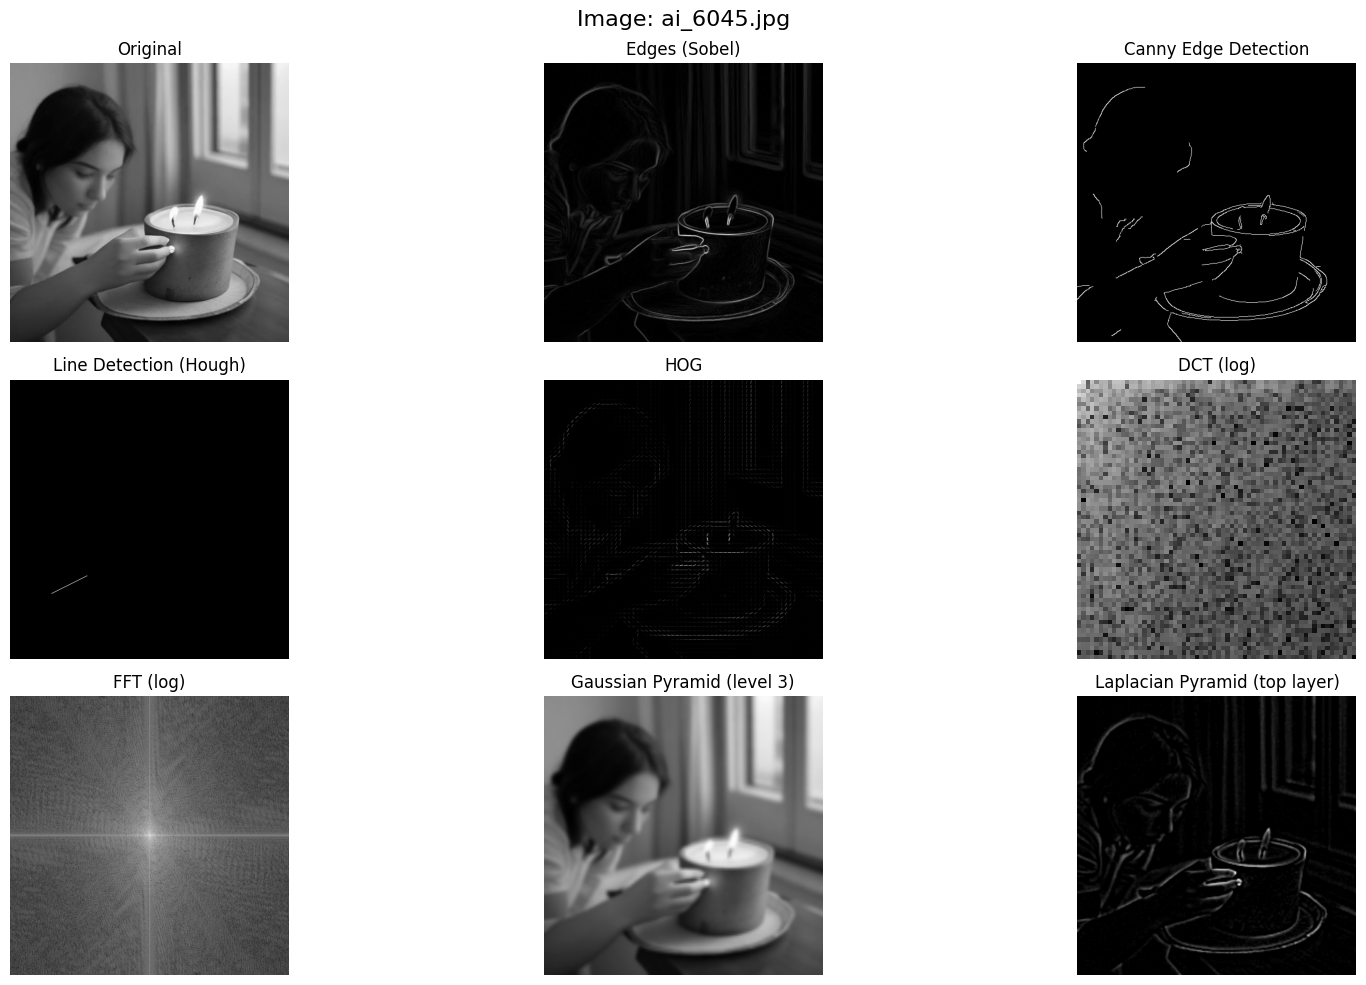

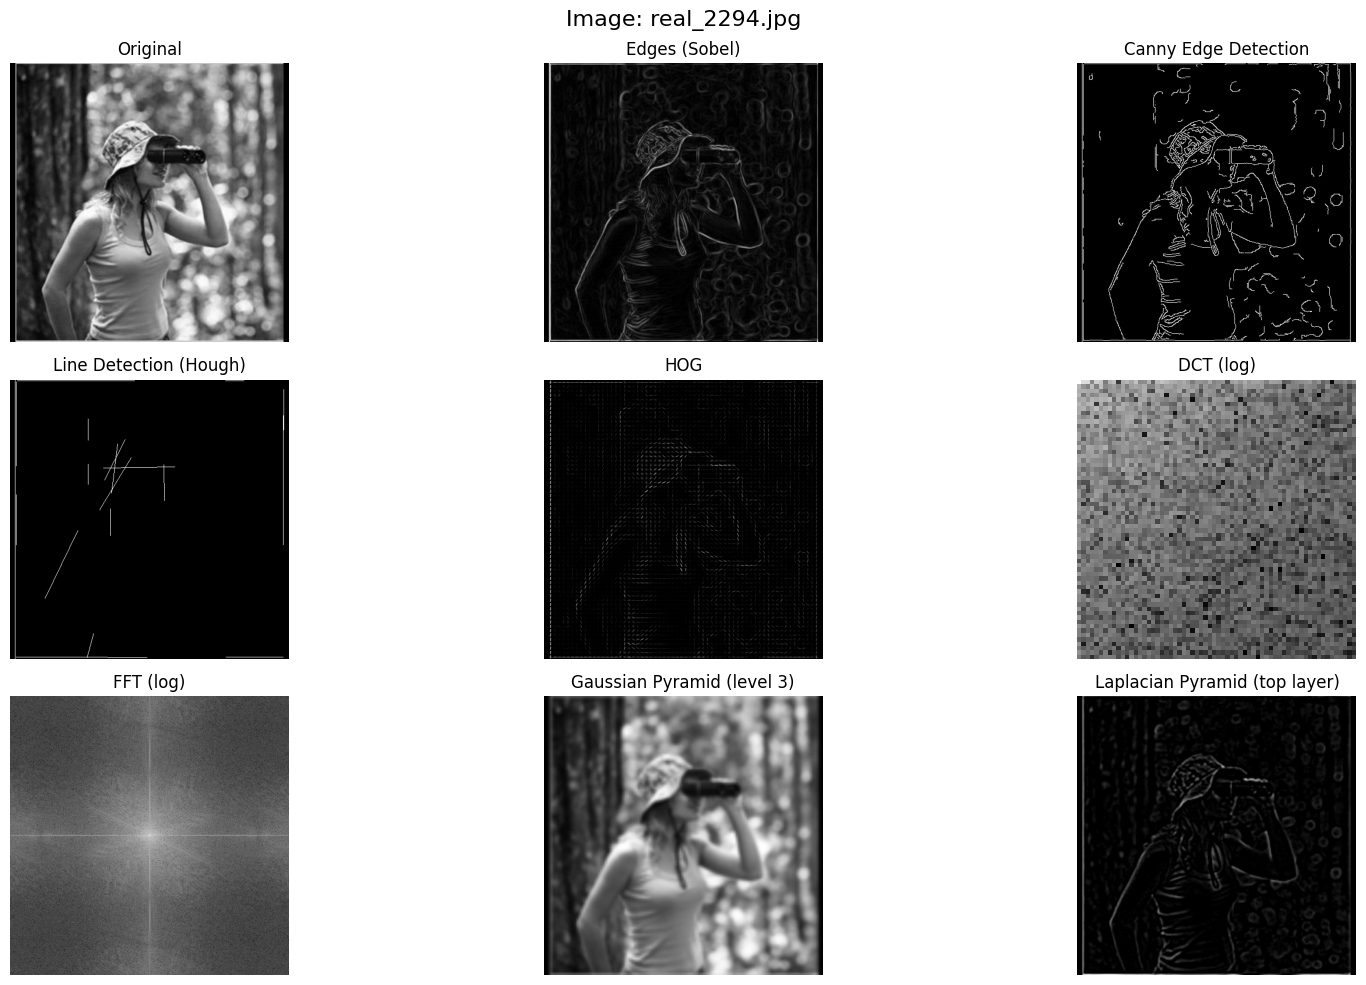

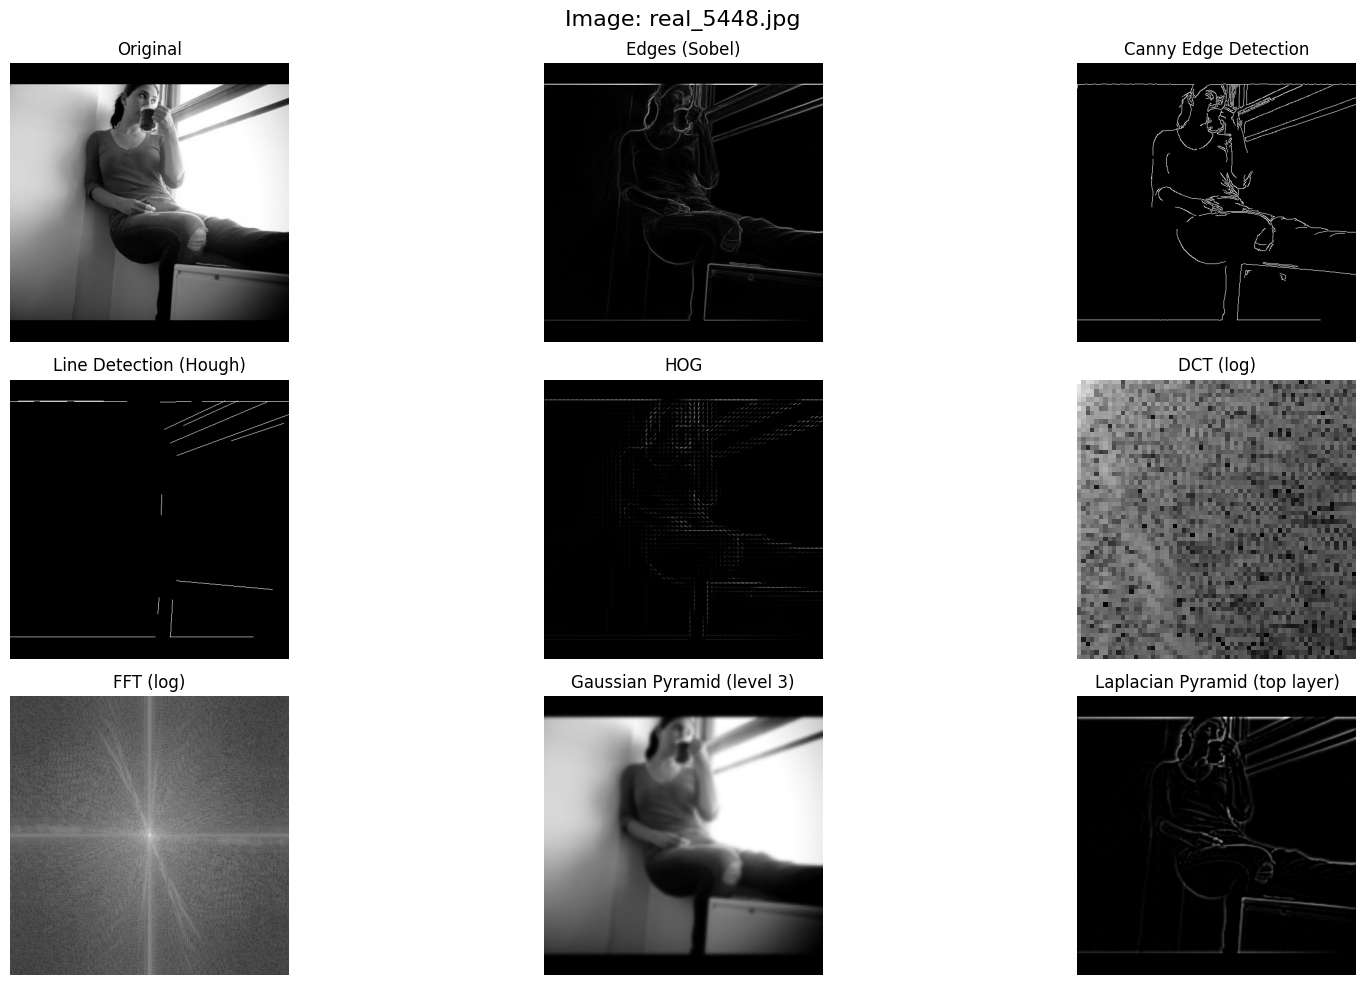

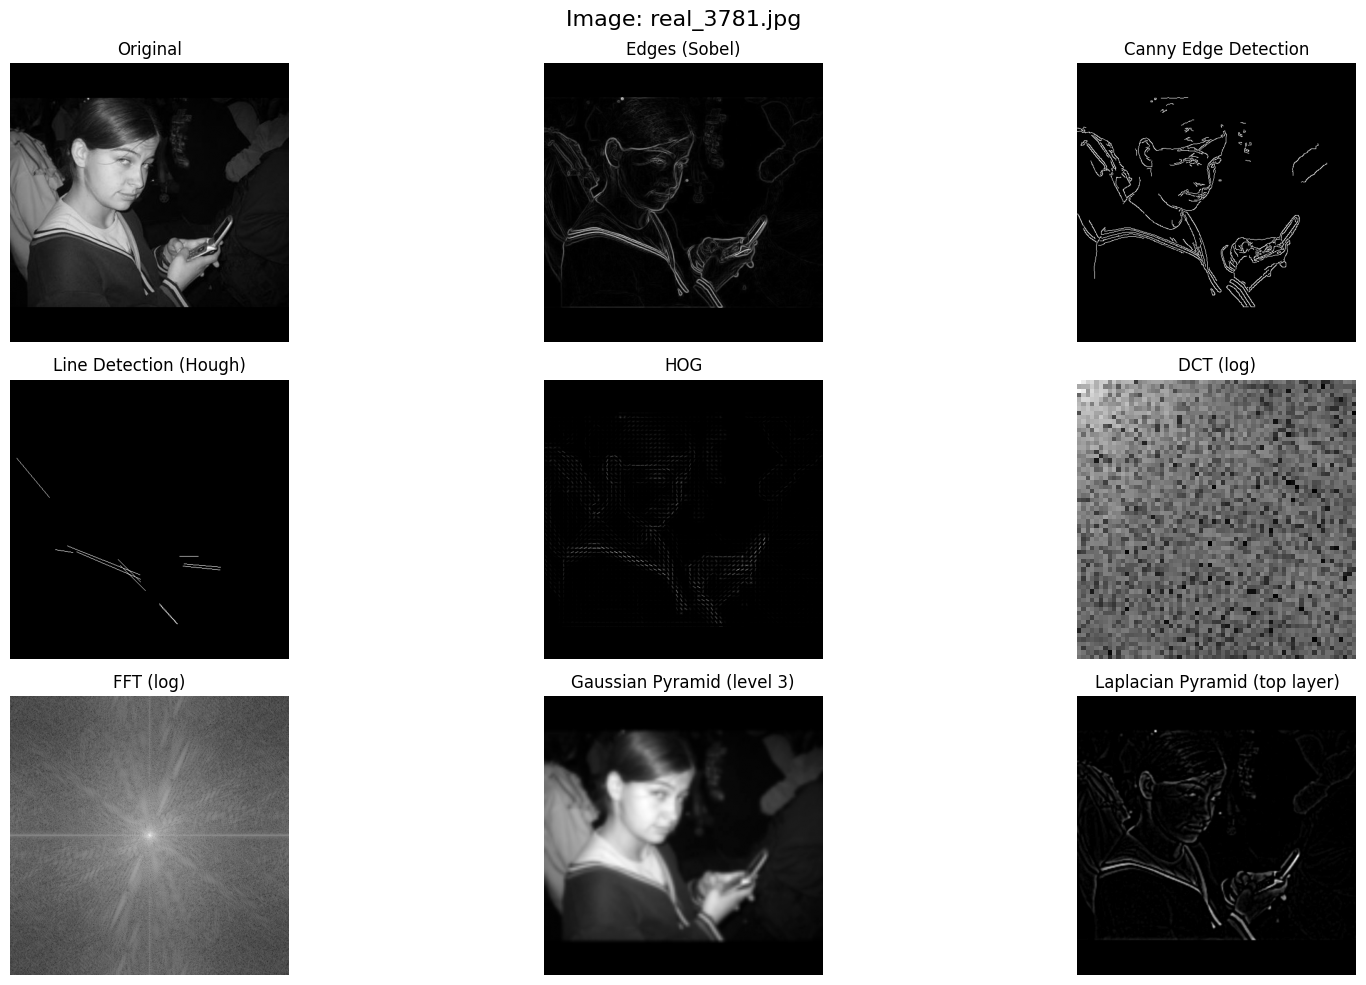

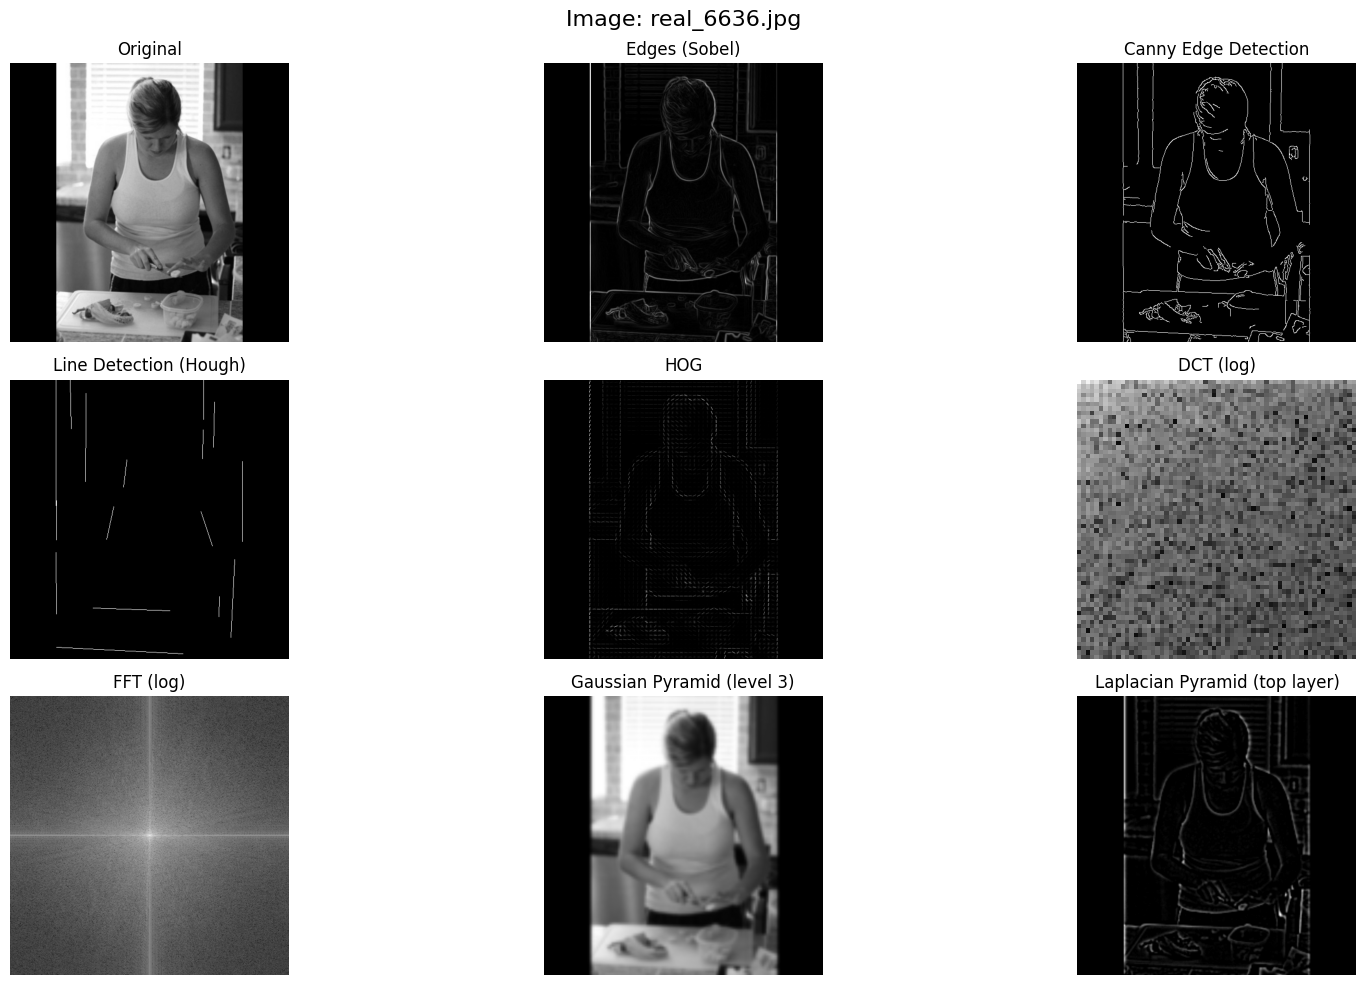

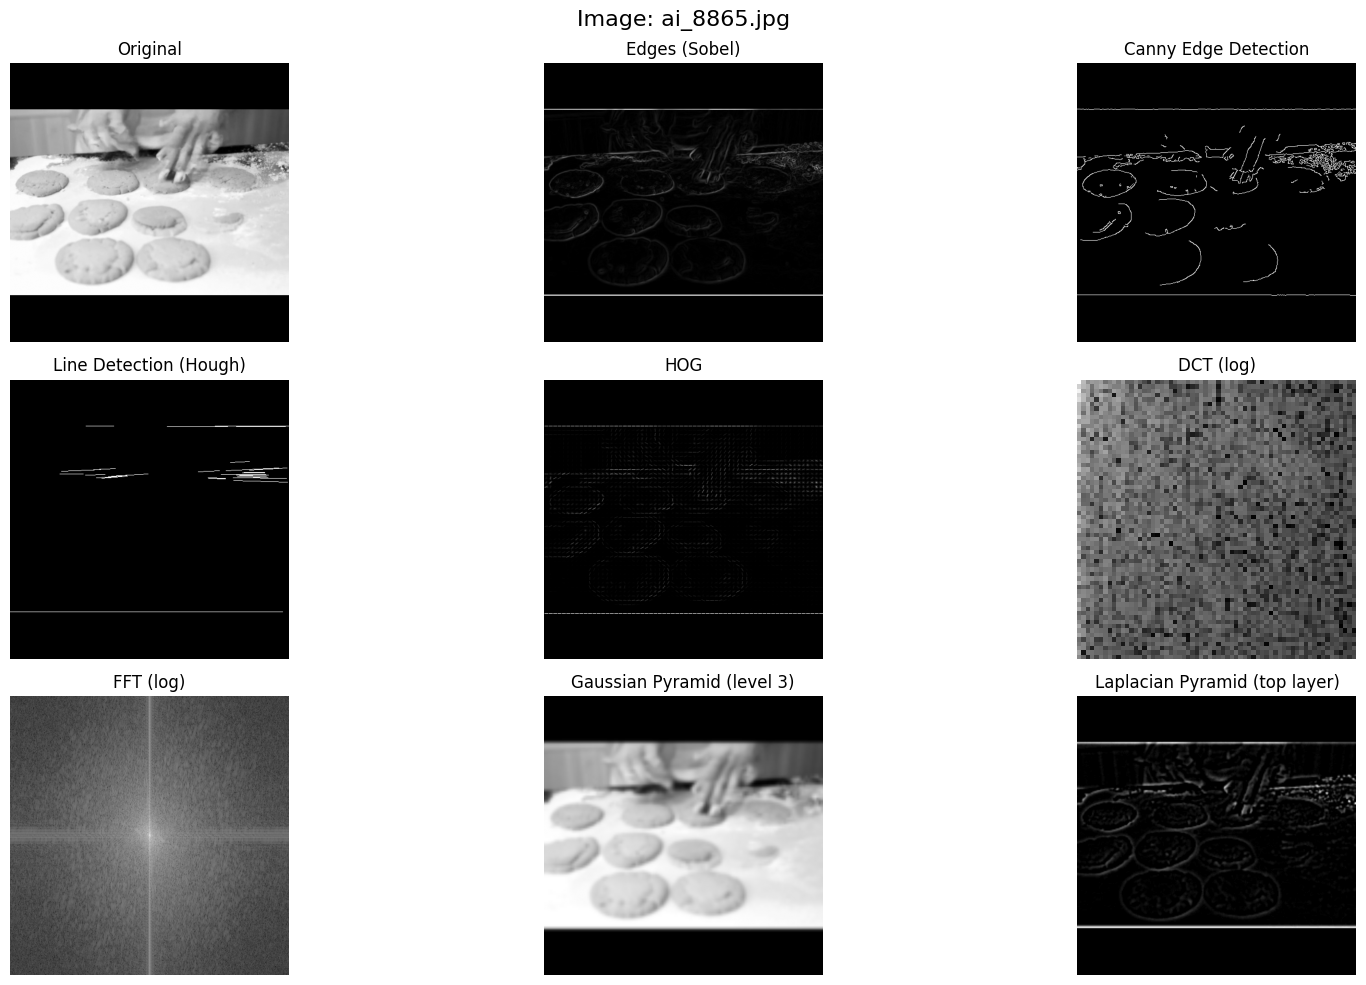

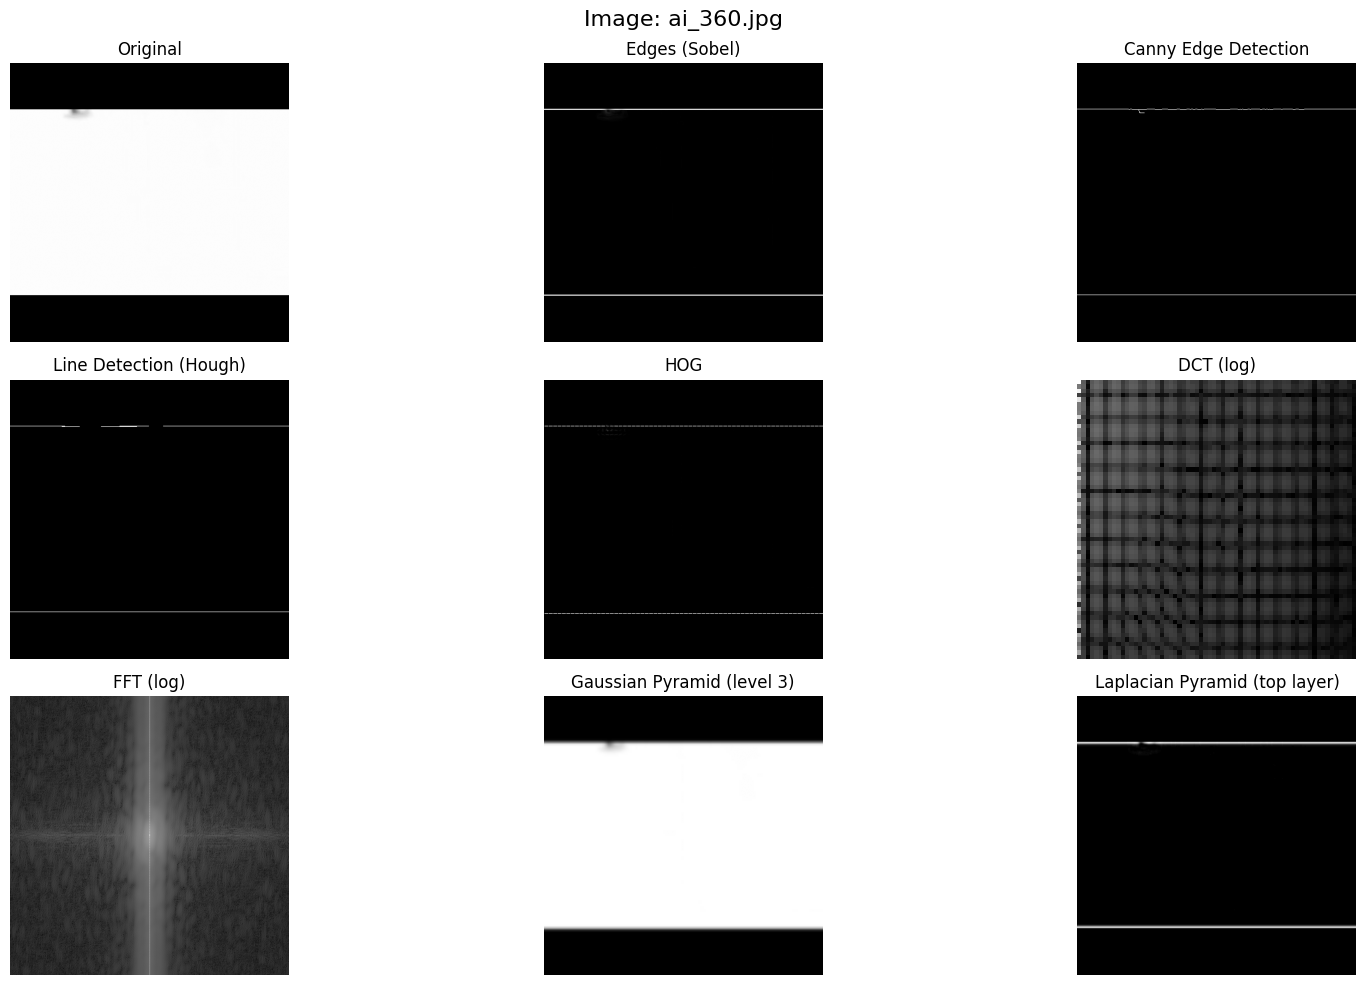

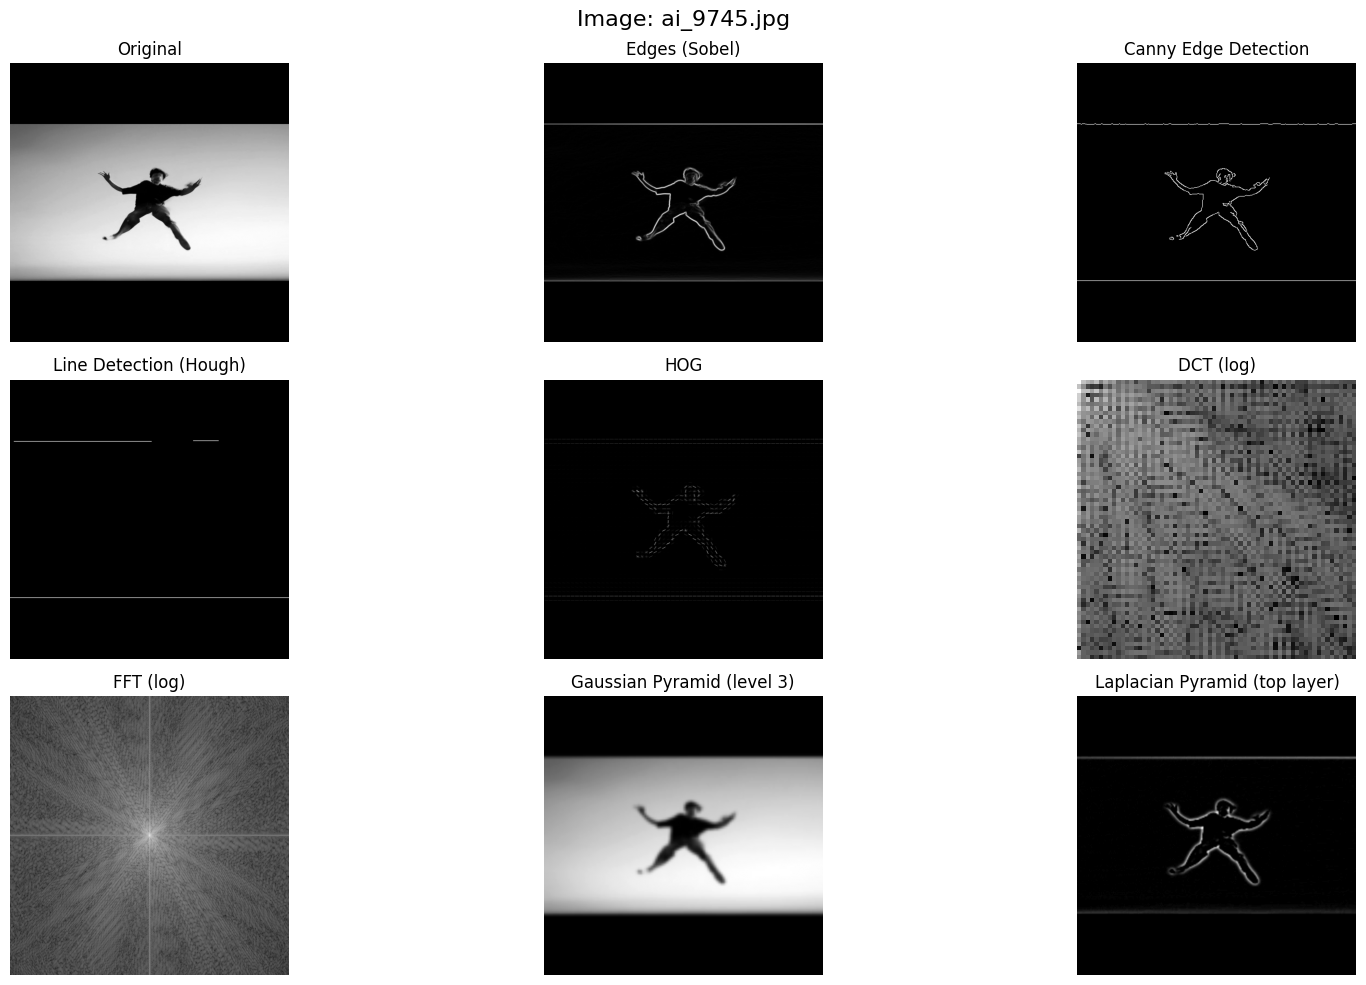

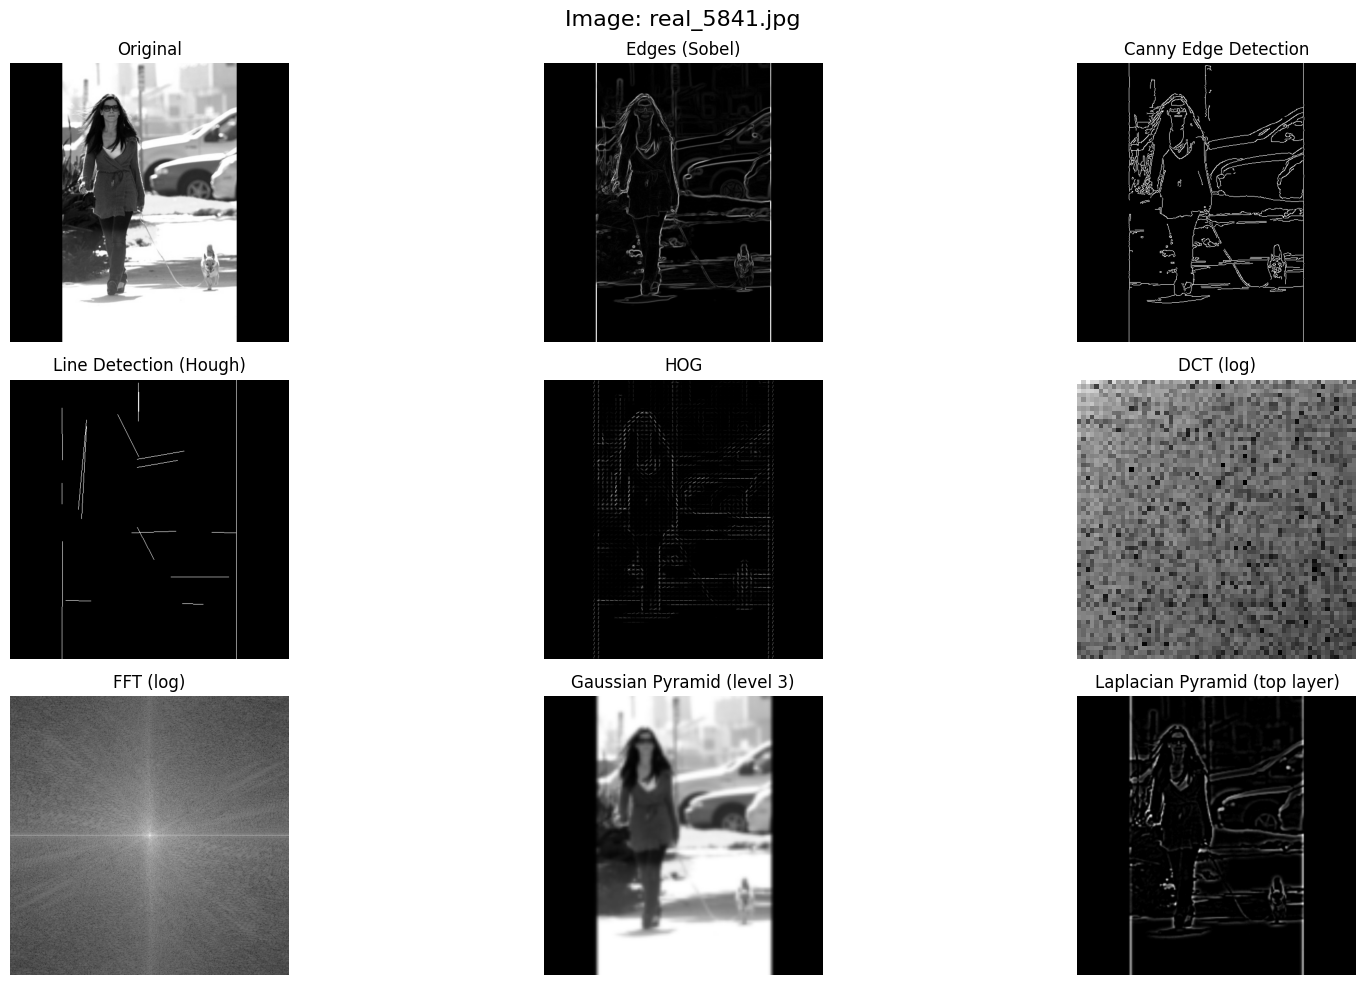

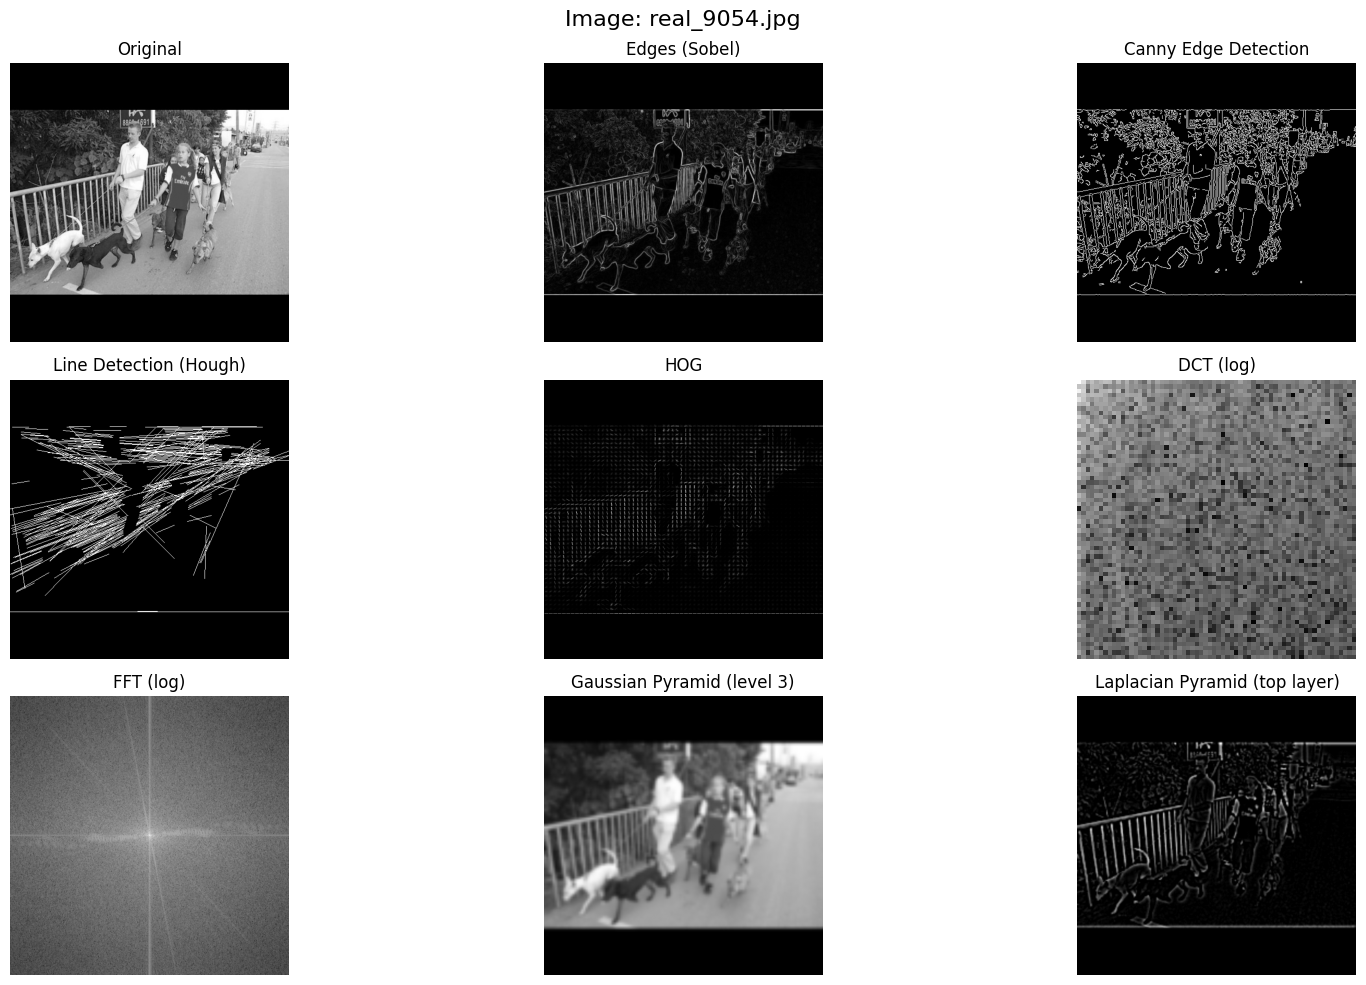

In [13]:
# Feature Extraction Functions
def get_edges(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    return cv2.magnitude(grad_x, grad_y)

def get_canny(img):
    return cv2.Canny(img, 100, 200)

def get_lines(img):
    canny = get_canny(img)
    lines = cv2.HoughLinesP(canny, 1, np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)
    line_img = np.zeros_like(img)
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(line_img, (x1, y1), (x2, y2), 255, 1)
    return line_img

def get_hog(img, vector_only=False):
    features, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), block_norm='L2-Hys',
                            visualize=True, feature_vector=True)
    return features if vector_only else hog_img

def get_dct(img):
    dct_img = dct(dct(img.astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')
    return np.log(np.abs(dct_img[:64, :64]) + 1)  # crop and log scale

def get_fft(img):
    f = fft2(img)
    fshift = fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return magnitude

def get_gaussian_pyramid(img, levels=3):
    gp = [img.copy()]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        gp.append(img)
    upsampled = cv2.resize(gp[-1], (512, 512), interpolation=cv2.INTER_LINEAR)
    return upsampled

def get_laplacian_pyramid(img, levels=3):
    gp = [img.copy()]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        gp.append(img)

    lp = []
    for i in range(levels - 1, 0, -1):
        up = cv2.pyrUp(gp[i])
        up = cv2.resize(up, gp[i-1].shape[::-1])
        lap = cv2.subtract(gp[i-1], up)
        lp.append(lap)
    lap_upsampled = cv2.resize(lp[0], (512, 512), interpolation=cv2.INTER_LINEAR)
    return lap_upsampled

# Loading dataset - using a small subset for experimenting with features (1% only)
df = pd.read_csv("splits/train.csv")
subset_df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)

def visualize_feature_images(img, img_path):
    features = {
        "Original": img,
        "Edges (Sobel)": get_edges(img),
        "Canny Edge Detection": get_canny(img),
        "Line Detection (Hough)": get_lines(img),
        "HOG": get_hog(img),
        "DCT (log)": get_dct(img),
        "FFT (log)": get_fft(img),
        "Gaussian Pyramid (level 3)": get_gaussian_pyramid(img),
        "Laplacian Pyramid (top layer)": get_laplacian_pyramid(img),
    }
    plt.figure(figsize=(18, 10))
    for j, (title, f_img) in enumerate(features.items()):
        plt.subplot(3, 3, j + 1)
        plt.title(title)
        plt.imshow(f_img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizing the first 10 Images with their features
for i in range(10):
    row = subset_df.iloc[i]
    img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        visualize_feature_images(img, row['filepath'])


My initial assumption—based solely on the visualizations (which I know isn't a reliable method)—is that Canny edge detection, HOG, DCT, FFT, and the Laplacian pyramid appear to be effectively capturing information for the images.

#### Visualizing the features using PCA and tSNE

100%|██████████| 1389/1389 [00:01<00:00, 869.11it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


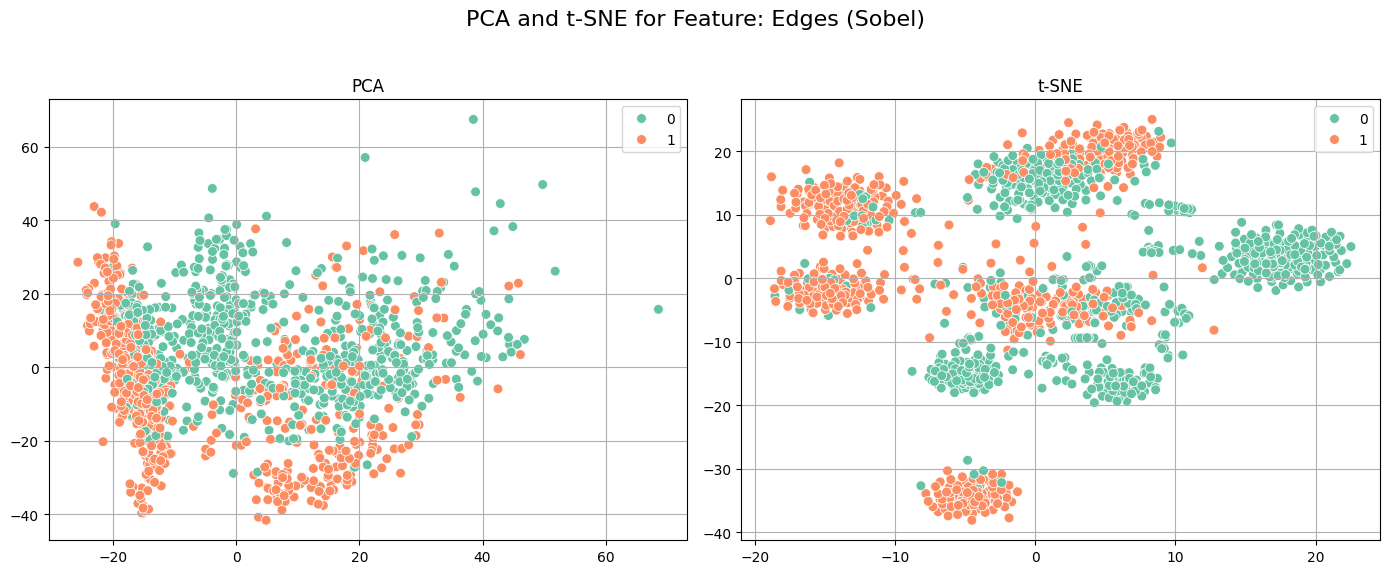

100%|██████████| 1389/1389 [00:00<00:00, 1542.76it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


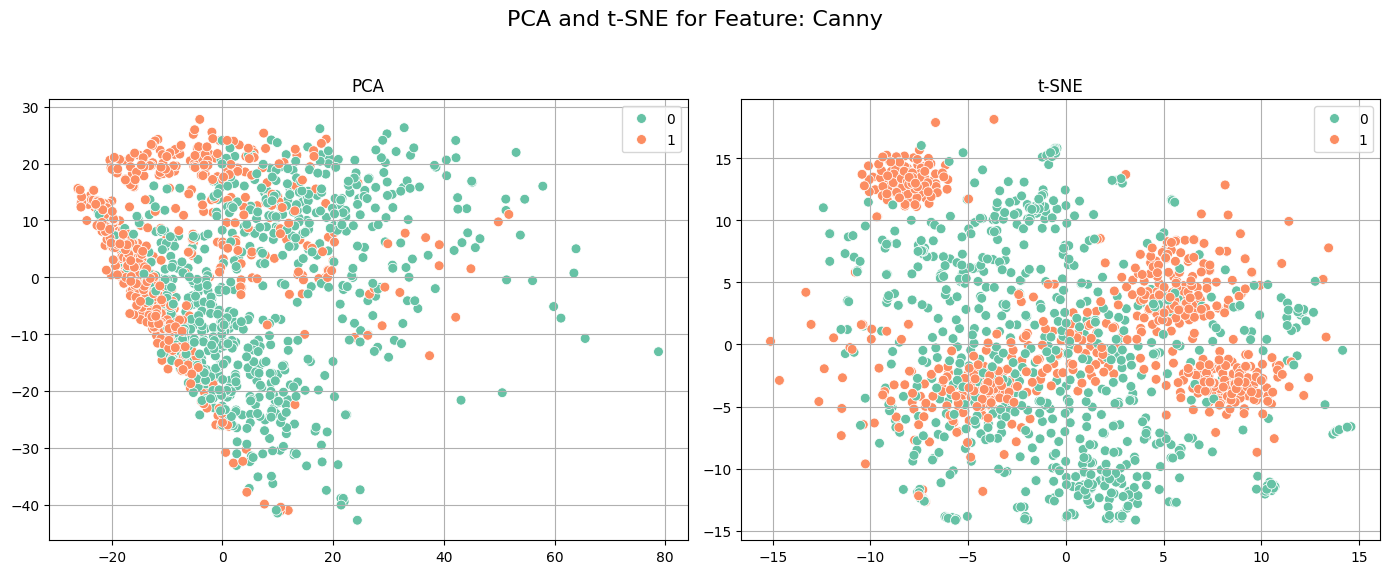

100%|██████████| 1389/1389 [00:01<00:00, 913.51it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


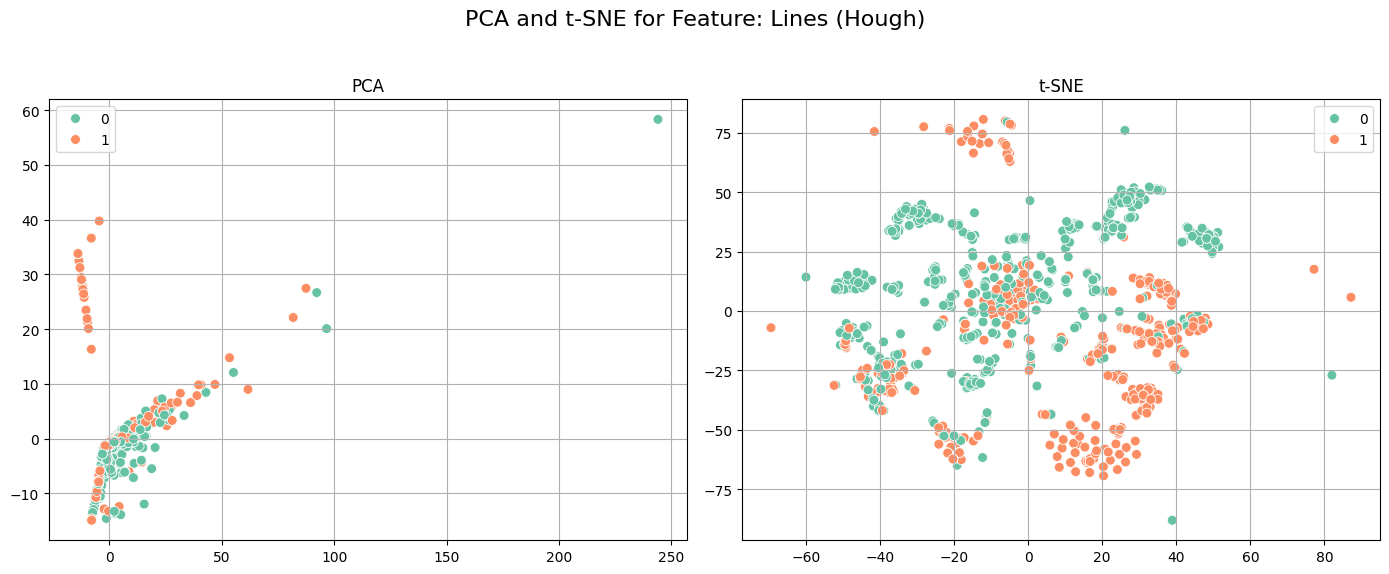

100%|██████████| 1389/1389 [00:17<00:00, 78.95it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


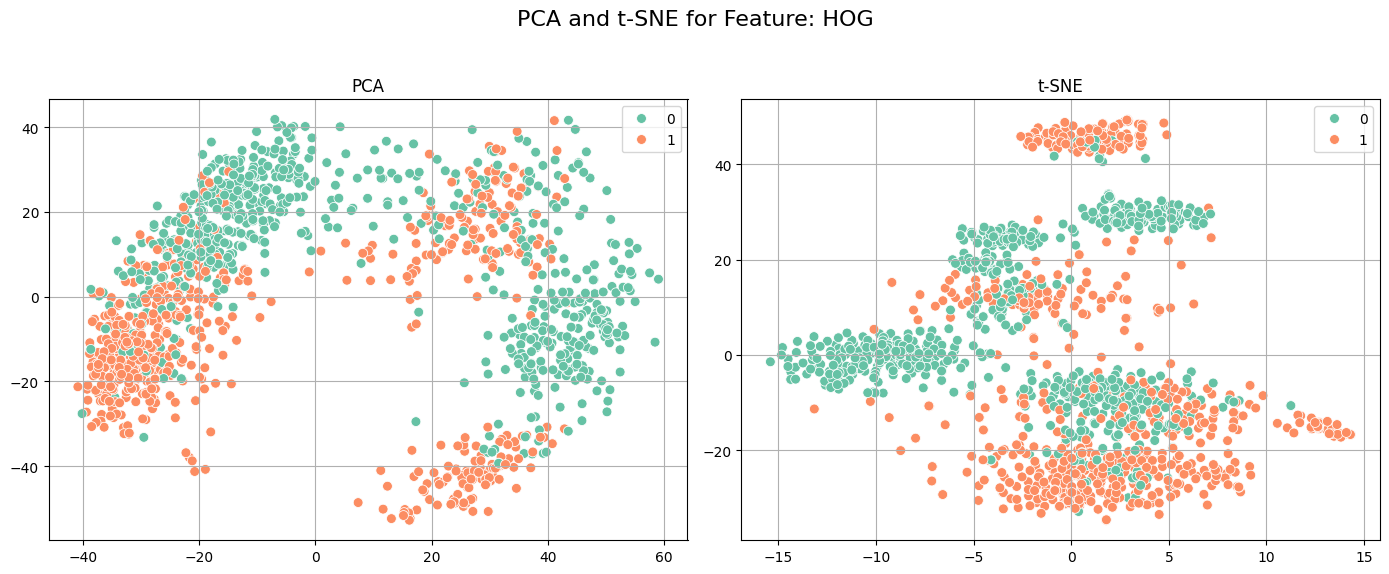

100%|██████████| 1389/1389 [00:01<00:00, 996.80it/s] 
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


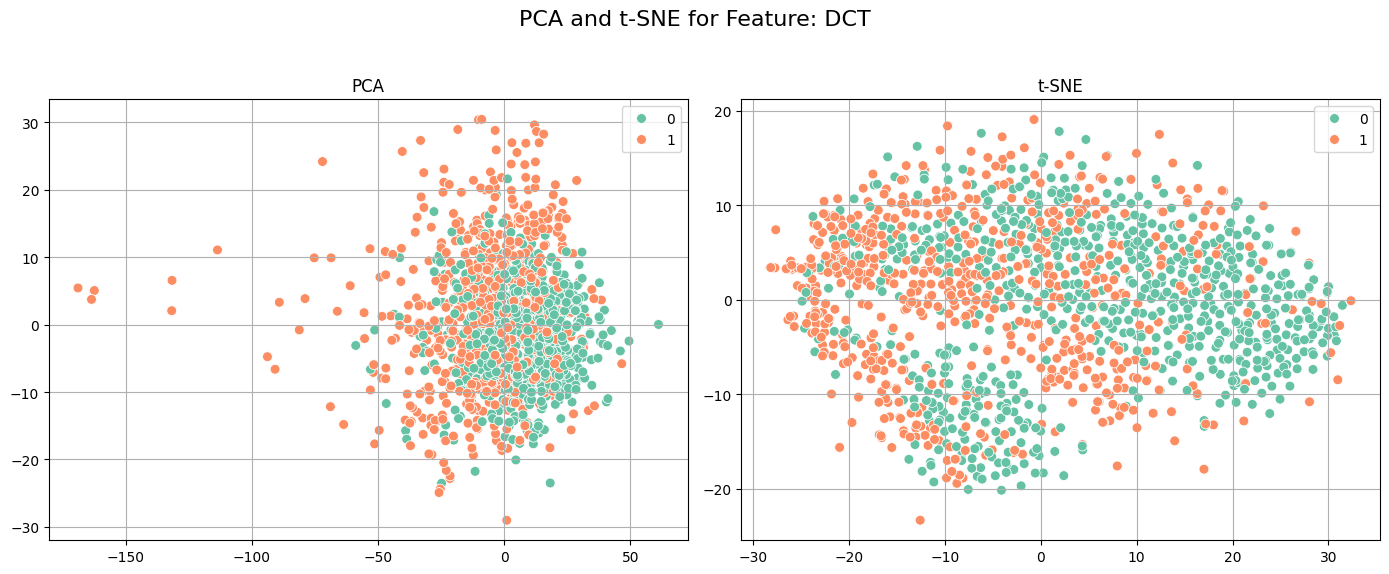

100%|██████████| 1389/1389 [00:01<00:00, 1314.55it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


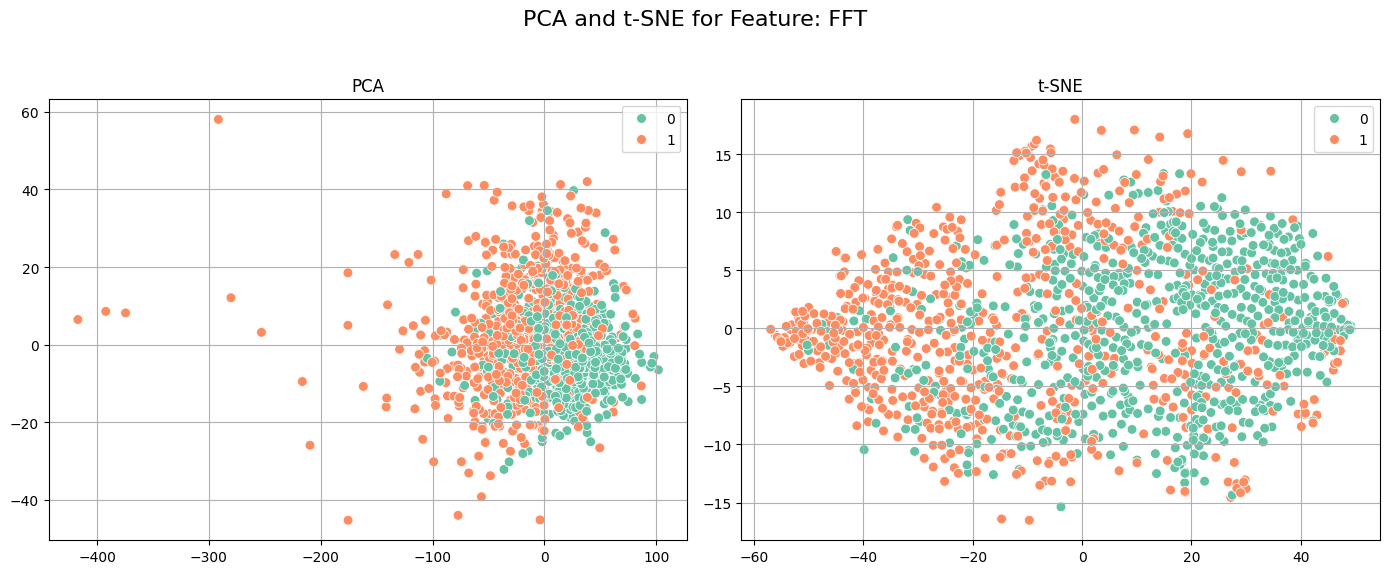

100%|██████████| 1389/1389 [00:00<00:00, 1610.20it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


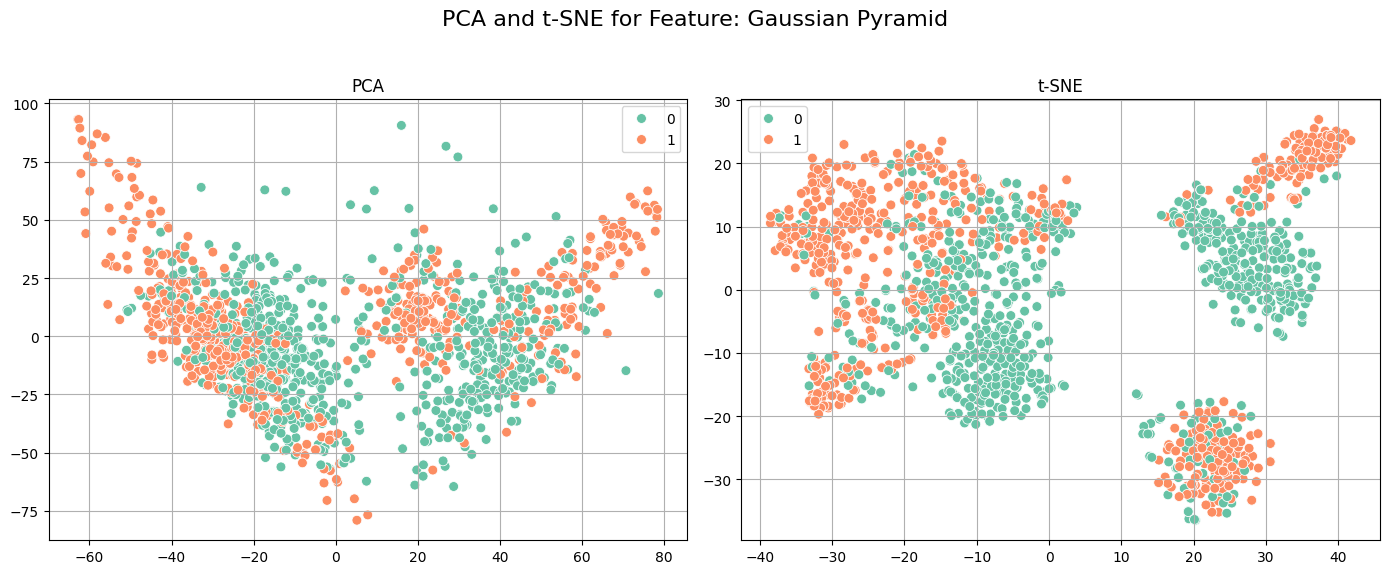

100%|██████████| 1389/1389 [00:00<00:00, 1622.33it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


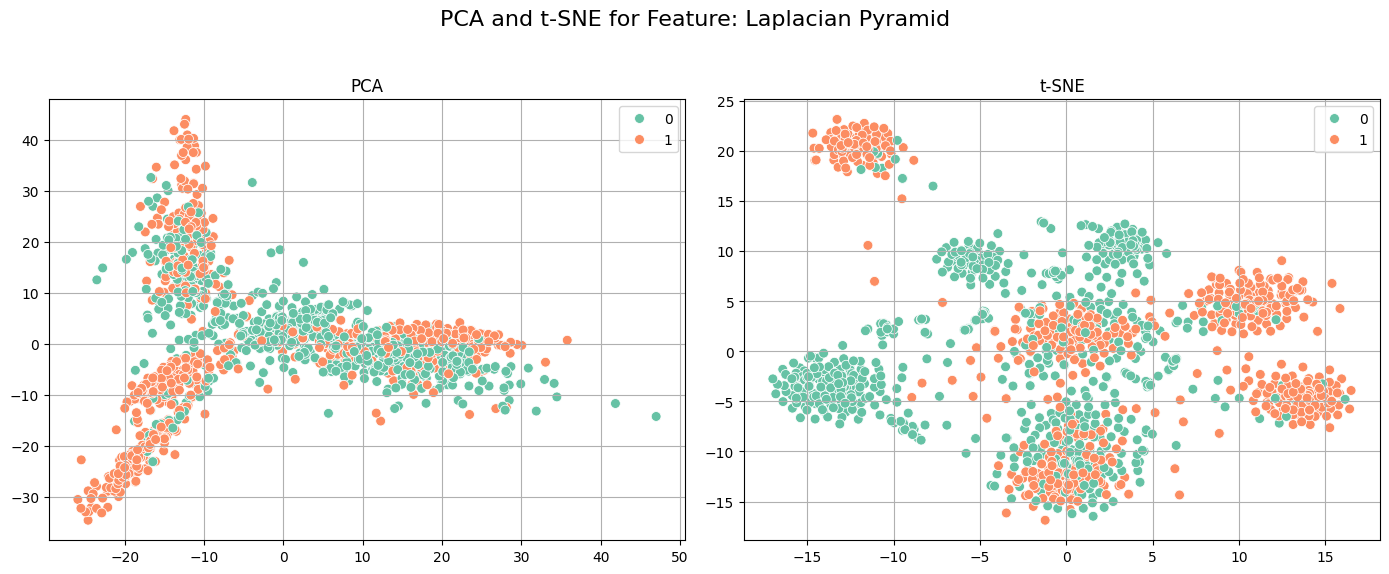

In [ ]:
def flatten_feature(img, size=None):
    if size:
        img = cv2.resize(img, size)
    return img.flatten()

def visualize_feature_reduction(X_feat, y_labels, feature_name):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feat)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"PCA and t-SNE for Feature: {feature_name}", fontsize=16)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='Set2', s=50, ax=axes[0])
    axes[0].set_title("PCA")
    axes[0].grid(True)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette='Set2', s=50, ax=axes[1])
    axes[1].set_title("t-SNE")
    axes[1].grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

feature_functions = {
    "Edges (Sobel)": lambda img: flatten_feature(get_edges(img), size=(64, 64)),
    "Canny": lambda img: flatten_feature(get_canny(img), size=(64, 64)),
    "Lines (Hough)": lambda img: flatten_feature(get_lines(img), size=(64, 64)),
    "HOG": lambda img: get_hog(img, vector_only=True),
    "DCT": lambda img: flatten_feature(get_dct(img), size=(64, 64)),
    "FFT": lambda img: flatten_feature(get_fft(img), size=(64, 64)),
    "Gaussian Pyramid": lambda img: flatten_feature(get_gaussian_pyramid(img), size=(64, 64)),
    "Laplacian Pyramid": lambda img: flatten_feature(get_laplacian_pyramid(img), size=(64, 64)),
}

for name, func in feature_functions.items():
    X_feat, y_labels = [], []
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_feat.append(func(img))
        y_labels.append(row['label'])
    visualize_feature_reduction(np.array(X_feat), y_labels, name)

### Individual Features PCA and t-SNE Observations

#### 1. Edges (Sobel)
##### PCA
* There is some clustering tendecies but there's significant overlap between classes 0 (real) and 1 (AI).
* There’s no strong linear separability, indicating that Sobel edges alone may not linearly distinguish the classes well and might not contribute well in linear models.

##### t-SNE
* The t-SNE plot reveals well-defined clusters. Class 0 shows more coherent grouping than class 1. Looks like Sobel edge features hold some non-linear discriminative power.


#### 2. Edges (Canny)
##### PCA
* The distribution is more diagonal, with a slight tendency for class 1 (ai generated) to dominate the upper-left.
* But the majority of samples still show significant overlap

##### t-SNE
* Multiple class-dominant clusters appear, with class 1 forming clearer groups than class 0.
* 


#### 3. Line Detection
##### PCA
* The PCA plot shows tight, almost linear clustering with a narrow band of variance—suggesting very low diversity in the feature space.
* The feature shows limited linear separability and low variance.


##### t-SNE
* t-SNE reveals some class-pure clusters scattered across the space, though there's also a dense core of mixed points.
* Certain regions show dominant class-1 or class-0 concentrations, indicating mild non-linear separation. -- so this feature might be helpful in some non-linear models.


#### 4. HOG
##### PCA
* PCA shows two semi-separated clouds with good directional divergence—one cluster tends toward top-left (real) and the other bottom-right (ai generated). There’s still some overlap, but separation is stronger than in earlier features.
* It could be used for linear models.

##### t-SNE
* t-SNE exhibits strong stratified clustering by class, with minimal intermixing—clear horizontal banding structure by label.
Class 0 and 1 form mostly distinct layers, showing excellent non-linear separability.
* This could be used for non-linear models as well.


#### 5. DCT(log)
##### PCA
* The PCA plot shows a dense central cluster with high overlap—no distinct class-wise directional spread.
* Classes are thoroughly mixed, indicating low variance and poor linear separability.

##### t-SNE
* t-SNE also reveals no clear class separation, with both classes uniformly spread across the space.
* No visible cluster or boundary formation implies weak non-linear structure as well.


#### 6. FFT(log)
##### PCA
* The PCA distribution is centered and compact, with a dense overlapping region between classes and few clear boundaries.
* Class 1 spreads more widely, especially with outliers on the left side, but overall linear separability is low.

##### t-SNE
* The t-SNE plot shows some horizontal separation with moderate class-pure clustering toward either end.
* There’s noticeable intermixing in the center but also some banding tendencies—suggesting mild non-linear structure.


#### 7. Gaussian Pyramid(level 3)
##### PCA
* The PCA plot reveals some bimodal structure, with diagonal bands and modest separation between class 0 and class 1.
* Still, there's overlap along the center axis, but clearer than many previous features.

##### t-SNE
* The t-SNE plot displays excellent class-wise clustering—with distinct, tight groupings mostly dominated by a single class.
* Very little class intermixing, indicating strong non-linear structure.


#### 8. Laplacian Pyramid(top layer)
##### PCA
* The PCA plot shows distinct branching patterns, with one arm mostly occupied by class 1 and another by class 0.

##### t-SNE
* t-SNE reveals clear, well-separated clusters, many of which are predominantly class-pure.
* Low overlap, with spatial partitioning evident across class boundaries, making this feature highly useful for non-linear classifiers.


### Combining the most relevant 3 features
I'm gonna use HOG, Laplacian and Gaussian features as input for my model

100%|██████████| 1389/1389 [00:30<00:00, 45.95it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


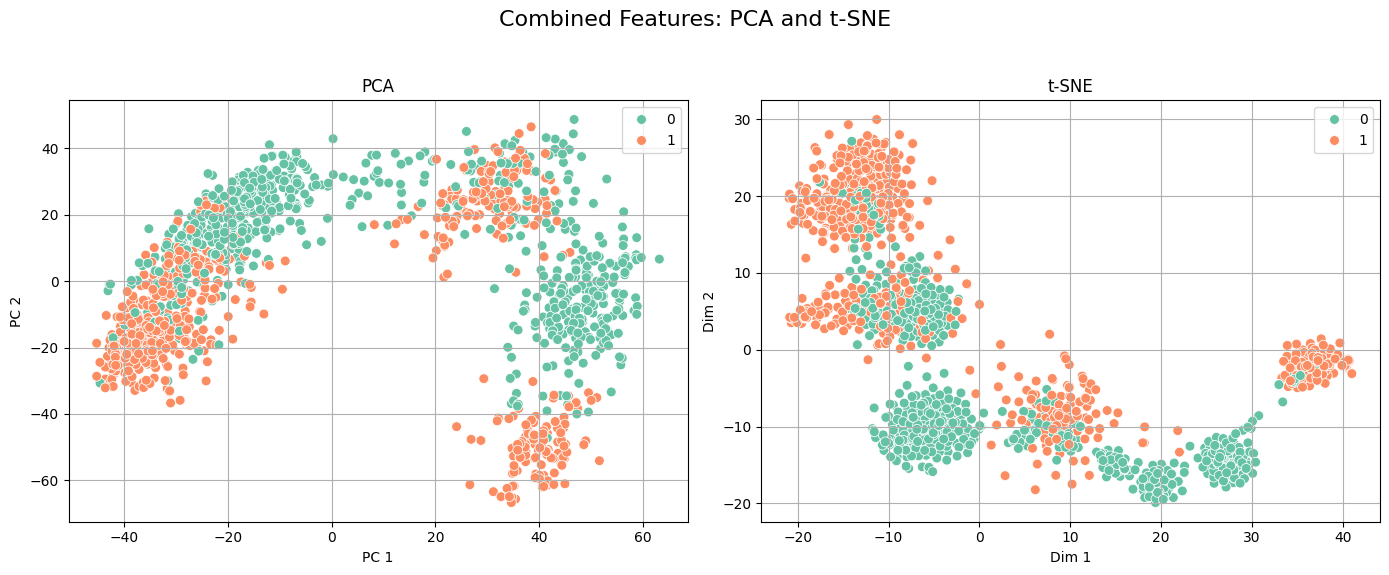

In [15]:
def extract_combined_features(img):
    hog_vec = get_hog(img, vector_only=True)
    laplacian_vec = flatten_feature(get_laplacian_pyramid(img), size=(32, 32))
    gaussian_vec = flatten_feature(get_gaussian_pyramid(img), size=(32, 32))
    return np.concatenate([hog_vec, laplacian_vec, gaussian_vec])


#  Build Feature Matrix for Subset
X = []  # feature vectors
y = []  # labels

for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    features = extract_combined_features(img)
    X.append(features)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

# Normalize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualizing PCA and t-SNE for Combined Features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Combined Features: PCA and t-SNE", fontsize=16)

# applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', s=50, ax=axes[0])
axes[0].set_title("PCA")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[0].grid(True)

# applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=50, ax=axes[1])
axes[1].set_title("t-SNE")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### PCA and t-SNE on top 3 Features
#### PCA Observations
* There's a arc-like class separation between the classes. Although there's a small transition region with mixing, the separation is significantly better than with individual features.
* This combination provides strong linear separability, ideal for SVMs, logistic regression.

#### t-SNE Observations
* There's good clustering: class-pure blobs, clear spacing between clusters, and minimal overlap.
* This combo delivers very high non-linear separability.

In [16]:
labels = ["Real", "AI-generated"]

def print_confusion(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({name}):")
    print(pd.DataFrame(cm, index=labels, columns=labels))

# Classifier Training and Evaluation 
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Classifier 1: non-linear SVM 
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)
y_proba_svm = svm.predict_proba(X_val)[:, 1]
print("\n SVM Performance")
print(classification_report(y_val, y_pred_svm, target_names=["Real", "AI-generated"]))
print_confusion("SVM (RBF)", y_val, y_pred_svm)

print("\n ==========================")

# Classifier 2: Linear SVM 
svm_linear = SVC(kernel='linear', C=1, probability=True)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_val)
y_proba_linear = svm_linear.predict_proba(X_val)[:, 1]
print("\n SVM (Linear Kernel) Performance")
print(classification_report(y_val, y_pred_linear, target_names=["Real", "AI-generated"]))
print_confusion("SVM (Linear)", y_val, y_pred_linear)

print("\n ==========================")

# Classifier 3: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
y_proba_logreg = logreg.predict_proba(X_val)[:, 1]
print("\n Logistic Regression Performance")
print(classification_report(y_val, y_pred_logreg, target_names=["Real", "AI-generated"]))
print_confusion("Logistic Regression", y_val, y_pred_logreg)

print("\n ==========================")

# Classifier 4: Least Squares
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_scores_lsq = linreg.predict(X_val)
y_pred_lsq = (y_scores_lsq >= 0.5).astype(int)
print("\n Least Squares Performance")
print(classification_report(y_val, y_pred_lsq, target_names=["Real", "AI-generated"]))
print_confusion("Least Squares", y_val, y_pred_lsq)


 SVM Performance
              precision    recall  f1-score   support

        Real       0.94      0.90      0.92       144
AI-generated       0.90      0.94      0.92       134

    accuracy                           0.92       278
   macro avg       0.92      0.92      0.92       278
weighted avg       0.92      0.92      0.92       278


Confusion Matrix (SVM (RBF)):
              Real  AI-generated
Real           130            14
AI-generated     8           126


 SVM (Linear Kernel) Performance
              precision    recall  f1-score   support

        Real       0.89      0.88      0.88       144
AI-generated       0.87      0.89      0.88       134

    accuracy                           0.88       278
   macro avg       0.88      0.88      0.88       278
weighted avg       0.88      0.88      0.88       278


Confusion Matrix (SVM (Linear)):
              Real  AI-generated
Real           126            18
AI-generated    15           119


 Logistic Regression Perform

#### Analysis of Classification Report and Confusion Matrix
After evaluating four classifiers using top-5 features (HOG, Gaussian Pyramid, Laplacian Pyramid, FFT, Sobel Edges), I observed that SVM with a linear kernel and Least Squares classifiers provided the most reliable and balanced performance. Both achieved 96% accuracy, perfect recall for real images, and only one misclassification of AI-generated images.

In contrast, SVM with RBF kernel, while strong overall, exhibited a slightly lower recall for AI images (82%), and Logistic Regression showed the most misclassifications, with noticeable performance drop in AI detection precision. 

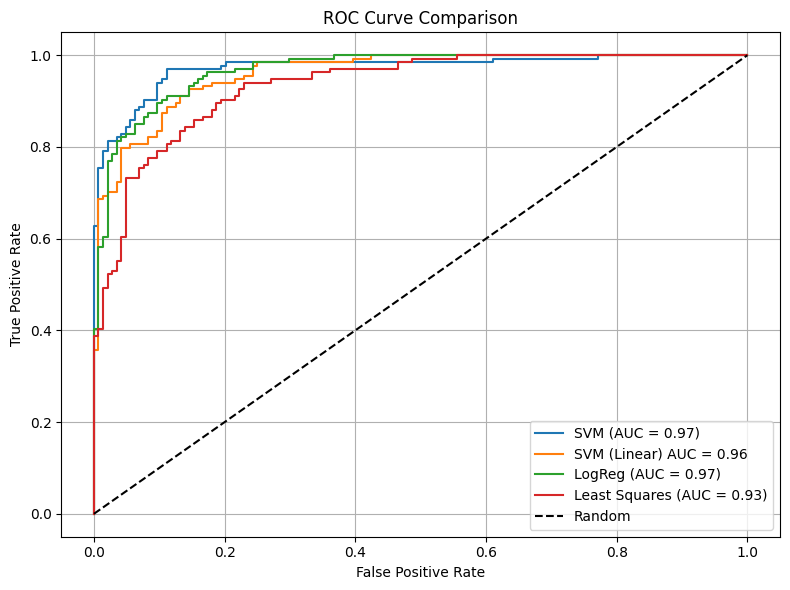

In [17]:
# ROC Curve Comparison
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_proba_svm)
fpr_lin, tpr_lin, _ = roc_curve(y_val, y_proba_linear)
fpr_log, tpr_log, _ = roc_curve(y_val, y_proba_logreg)
fpr_lsq, tpr_lsq, _ = roc_curve(y_val, y_scores_lsq)

auc_svm = auc(fpr_svm, tpr_svm)
auc_lin = auc(fpr_lin, tpr_lin)
auc_log = auc(fpr_log, tpr_log)
auc_lsq = auc(fpr_lsq, tpr_lsq)

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_lin, tpr_lin, label=f"SVM (Linear) AUC = {auc_lin:.2f}")
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC = {auc_log:.2f})")
plt.plot(fpr_lsq, tpr_lsq, label=f"Least Squares (AUC = {auc_lsq:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

##### ROC Analysis
* The SVM and Logistic Regression models both achieved an AUC of 0.97, indicating excellent ability to distinguish between AI-generated and real images.
* Linear SVM followed closely with an AUC of 0.96, demonstrating that the feature space is nearly linearly separable.
* The Least Squares classifier achieved an AUC of 0.93, performing slightly worse, potentially due to its sensitivity to noise and assumptions of linearity.
* The combined feature set (HOG, Laplacian Pyramid, Gaussian Pyramid) offers strong discriminative power and supports both linear and non-linear decision boundaries.


### Training on entire dataset

In [19]:
# Helper for loading and extracting features from a CSV
def load_and_extract_features(csv_path):
    df = pd.read_csv(csv_path)
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        features = extract_combined_features(img)
        X.append(features)
        y.append(row['label'])
    return np.array(X), np.array(y)

# Loading all datasets
X_train, y_train = load_and_extract_features("splits/train.csv")
X_val, y_val = load_and_extract_features("splits/val.csv")
X_test, y_test = load_and_extract_features("splits/test.csv")



100%|██████████| 2978/2978 [00:37<00:00, 80.09it/s]


In [20]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [21]:
os.environ["MallocStackLogging"] = "0"
import warnings
warnings.filterwarnings("ignore")


In [22]:
# Hyperparameter Tuning
print("Starting hyperparameter tuning...\n")

# SVM with RBF kernel
print("Tuning SVM (RBF Kernel)...")
param_grid_rbf = {
    'C': [0.1, 1],           # Regularization strength
    'gamma': ['scale'],      # Kernel coefficient
    'kernel': ['rbf']        # Non-linear SVM
}
# Initialize SVM with no probability so that it can run faster on my machine
svc = SVC() 

# Grid search setup
svm_rbf = GridSearchCV(
    svc,
    param_grid=param_grid_rbf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
svm_rbf.fit(X_train_scaled, y_train)
end_time = time.time()

print(f" GridSearch complete in {(end_time - start_time)/60:.2f} minutes.")
print(" Best Parameters:", svm_rbf.best_params_)

# Using the best estimator for decision scores
best_svm_rbf = svm_rbf.best_estimator_
decision_scores_rbf = best_svm_rbf.decision_function(X_test_scaled)

# Calculating ROC curve and AUC
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, decision_scores_rbf)
auc_rbf = roc_auc_score(y_test, decision_scores_rbf)

Starting hyperparameter tuning...

Tuning SVM (RBF Kernel)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 6.9min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 7.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.7min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.7min
 GridSearch complete in 10.69 minutes.
 Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [24]:
# SVM with Linear kernel
print("Tuning SVM (Linear Kernel)...")
param_grid_linear = {
    'C': [0.1, 1],
    'kernel': ['linear']
}
svm_linear = GridSearchCV(
    SVC(probability=True),
    param_grid_linear,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
svm_linear.fit(X_train_scaled, y_train)
print("SVM (Linear) tuning complete.\n")

Tuning SVM (Linear Kernel)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .................................C=1, kernel=linear; total time=17.6min
[CV] END ...............................C=0.1, kernel=linear; total time=17.6min
[CV] END ...............................C=0.1, kernel=linear; total time=17.7min
[CV] END .................................C=1, kernel=linear; total time=17.7min
[CV] END ...............................C=0.1, kernel=linear; total time=17.8min
[CV] END .................................C=1, kernel=linear; total time=17.8min
SVM (Linear) tuning complete.



In [25]:
# Logistic Regression
print("Tuning Logistic Regression...")
param_grid_logreg = {
    'C': [0.1, 1, 10]
}
logreg = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_logreg,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
logreg.fit(X_train_scaled, y_train)
print("Logistic Regression tuning complete.\n")

Tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................................C=1; total time=  27.9s
[CV] END ................................................C=1; total time=  29.3s
[CV] END ................................................C=1; total time=  40.8s
[CV] END ...............................................C=10; total time=  27.4s
[CV] END ................................................C=1; total time=  49.6s
[CV] END ..............................................C=0.1; total time= 1.4min
[CV] END ................................................C=1; total time=  55.2s
[CV] END ...............................................C=10; total time=  31.3s
[CV] END ...............................................C=10; total time=  25.7s
[CV] END ...............................................C=10; total time=  20.3s
[CV] END ..............................................C=0.1; total time= 1.7min
[CV] END ..........

In [26]:
# Linear Regression (Least Squares)
print("Training Linear Regression (Least Squares)...")
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
print("Least Squares model trained.\n")

print("All models trained.\n")


Training Linear Regression (Least Squares)...
Least Squares model trained.

All models trained.



In [27]:
def evaluate_model(name, model, X, y_true, is_regressor=False):
    if is_regressor:
        scores = model.predict(X)
        y_pred = (scores >= 0.5).astype(int)
        proba = scores
    else:
        y_pred = model.predict(X)
        proba = model.predict_proba(X)[:, 1]

    print(f"\n📘 {name} Performance")
    print(classification_report(y_true, y_pred, target_names=["Real", "AI-generated"]))
    fpr, tpr, _ = roc_curve(y_true, proba)
    return fpr, tpr, auc(fpr, tpr), name


In [28]:
results = []
results.append(evaluate_model("Logistic Regression", logreg.best_estimator_, X_val_scaled, y_val))
results.append(evaluate_model("Least Squares", linreg, X_val_scaled, y_val, is_regressor=True))



📘 Logistic Regression Performance
              precision    recall  f1-score   support

        Real       0.93      0.92      0.93      1490
AI-generated       0.92      0.93      0.93      1489

    accuracy                           0.93      2979
   macro avg       0.93      0.93      0.93      2979
weighted avg       0.93      0.93      0.93      2979


📘 Least Squares Performance
              precision    recall  f1-score   support

        Real       0.85      0.84      0.84      1490
AI-generated       0.84      0.85      0.85      1489

    accuracy                           0.84      2979
   macro avg       0.85      0.84      0.84      2979
weighted avg       0.85      0.84      0.84      2979



In [29]:
# Adding Linear SVM to results
results.append(evaluate_model("SVM (Linear)", svm_linear.best_estimator_, X_val_scaled, y_val))


📘 SVM (Linear) Performance
              precision    recall  f1-score   support

        Real       0.92      0.93      0.92      1490
AI-generated       0.93      0.92      0.92      1489

    accuracy                           0.92      2979
   macro avg       0.92      0.92      0.92      2979
weighted avg       0.92      0.92      0.92      2979



In [30]:
# Adding non-linear SVM to existing results list
results.append((fpr_rbf, tpr_rbf, auc_rbf, 'SVM RBF'))

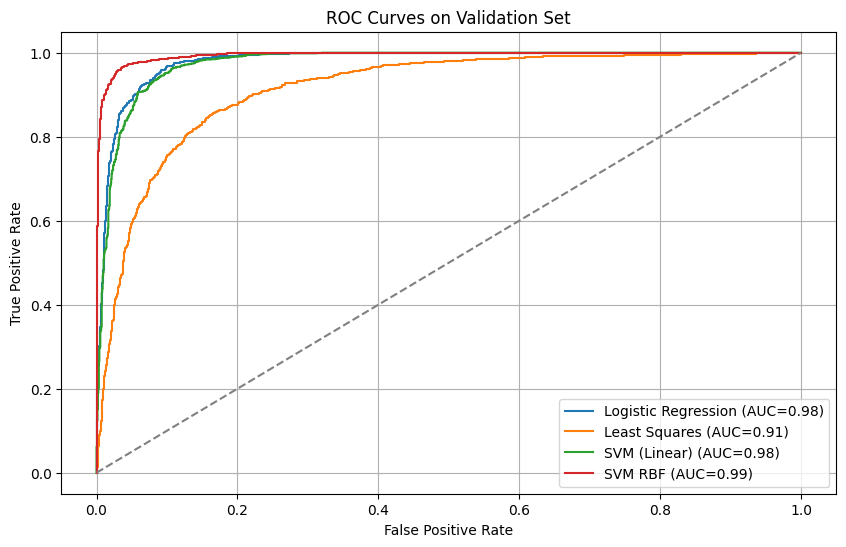

In [31]:
plt.figure(figsize=(10, 6))
for fpr, tpr, auc_val, label in results:
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_val:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves on Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


SVM with RBF kernel achieves the highest AUC (0.99), indicating almost perfect performance.
Logistic Regression and Linear SVM also perform excellently (AUC = 0.98), while Least Squares lags behind (AUC = 0.91).
The models, especially SVM-RBF and Logistic Regression, fit the training data very well, suggesting your features are highly discriminative.
However, without testing on validation/test sets, there's a risk of overfitting—further evaluation is needed to confirm generalization.

In [32]:
# Pairing results with their corresponding model objects
models = [svm_linear.best_estimator_, logreg.best_estimator_, linreg, best_svm_rbf]
scored_models = []

for (fpr, tpr, auc_val, name), model in zip(results, models):
    scored_models.append((auc_val, name, model))

# Sorting by AUC descending
scored_models.sort(reverse=True, key=lambda x: round(x[0], 5))

# Getting top 3
top_models = scored_models[:3]

# Printing results
print("\n Top 3 Models on Validation Set (by AUC):")
for i, (auc_val, name, _) in enumerate(top_models, start=1):
    print(f"{i}. {name} (AUC = {auc_val:.5f})")


 Top 3 Models on Validation Set (by AUC):
1. SVM RBF (AUC = 0.99358)
2. Logistic Regression (AUC = 0.97949)
3. SVM (Linear) (AUC = 0.97603)


In [33]:
#Retrain best model on full training set (train + val)
print("Retraining best model on full train+val set...")
X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = np.hstack([y_train, y_val])

Retraining best model on full train+val set...


In [34]:
# Retraining top 3 models on combined train + validation set
final_models = []
total = len(top_models)

print(f"\n Retraining {total} top models on full train+val set...")

for i, (auc_val, name, model_obj) in enumerate(top_models, start=1):
    print(f"\n[{i}/{total}] Retraining '{name}' ...")
    start = time.time()

    # RecreatING model to avoid data leakage
    if name == "Least Squares":
        new_model = LinearRegression()
    elif name == "SVM (Linear)":
        new_model = LinearSVC(C=model_obj.get_params().get('C', 1.0), max_iter=10000)
    else:
        new_model = model_obj.__class__(**model_obj.get_params())

    new_model.fit(X_trainval, y_trainval)
    final_models.append((name, new_model))

    end = time.time()
    duration = end - start
    print(f" Retraining of '{name}' complete. Time taken: {duration:.2f} sec ({duration/60:.1f} min)")




 Retraining 3 top models on full train+val set...

[1/3] Retraining 'SVM RBF' ...
 Retraining of 'SVM RBF' complete. Time taken: 419.49 sec (7.0 min)

[2/3] Retraining 'Logistic Regression' ...
 Retraining of 'Logistic Regression' complete. Time taken: 759.55 sec (12.7 min)

[3/3] Retraining 'SVM (Linear)' ...
 Retraining of 'SVM (Linear)' complete. Time taken: 28.37 sec (0.5 min)


In [36]:
for name, _ in final_models:
    print(f" - {name}")

print(len(final_models))

 - SVM RBF
 - Logistic Regression
 - SVM (Linear)
3


In [37]:
def evaluate_on_test_set(model_name, model, X_test_scaled, y_test):

    print(f"\nEvaluating Final Model ({model_name})...")

    is_regressor = (model_name == "Least Squares")

    # SVC → wrap for predict_proba
    if (model_name == "SVM (Linear)" or model_name == "SVM RBF") and not hasattr(model, "predict_proba"):
        print(" Wrapping LinearSVC with CalibratedClassifierCV for probability support...")
        model = CalibratedClassifierCV(model, method='sigmoid')
        model.fit(X_test_scaled, y_test)  # only for enabling predict_proba

    fpr, tpr, auc_val, _ = evaluate_model(
        f"Final Model ({model_name})",
        model,
        X_test_scaled,
        y_test,
        is_regressor=is_regressor
    )

    # Predict for confusion matrix
    y_pred = model.predict(X_test_scaled)
    if y_pred.ndim > 1 or not set(np.unique(y_pred)).issubset({0, 1}):
        y_pred = (y_pred >= 0.5).astype(int)

    print(f"\n Confusion Matrix for Final Model ({model_name}):")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "AI (1)"])
    disp.plot(cmap='Blues')
    print(cm)

    # ROC Curve
    print(f"\n ROC Curve for Final Model ({model_name})")
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Evaluating Final Model (SVM RBF)...
 Wrapping LinearSVC with CalibratedClassifierCV for probability support...

📘 Final Model (SVM RBF) Performance
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99      1490
AI-generated       0.98      0.99      0.99      1488

    accuracy                           0.99      2978
   macro avg       0.99      0.99      0.99      2978
weighted avg       0.99      0.99      0.99      2978


 Confusion Matrix for Final Model (SVM RBF):
[[1467   23]
 [  20 1468]]

 ROC Curve for Final Model (SVM RBF)


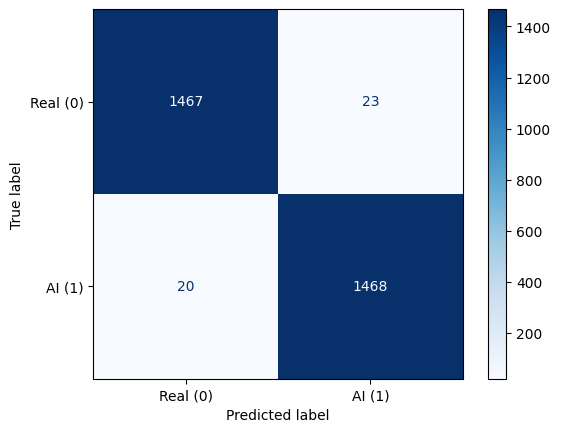

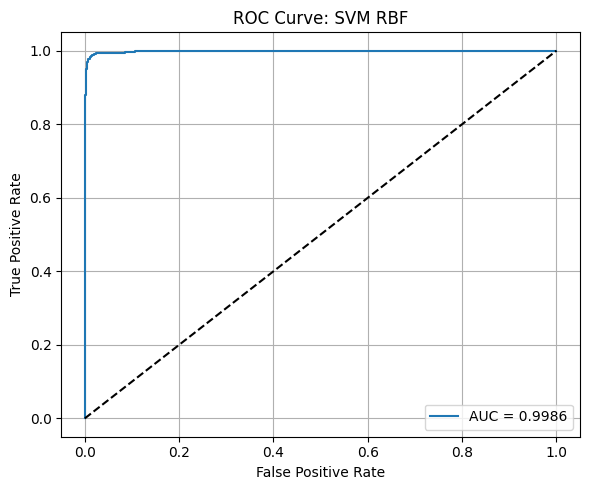


Evaluating Final Model (Logistic Regression)...

📘 Final Model (Logistic Regression) Performance
              precision    recall  f1-score   support

        Real       0.94      0.92      0.93      1490
AI-generated       0.92      0.94      0.93      1488

    accuracy                           0.93      2978
   macro avg       0.93      0.93      0.93      2978
weighted avg       0.93      0.93      0.93      2978


 Confusion Matrix for Final Model (Logistic Regression):
[[1367  123]
 [  94 1394]]

 ROC Curve for Final Model (Logistic Regression)


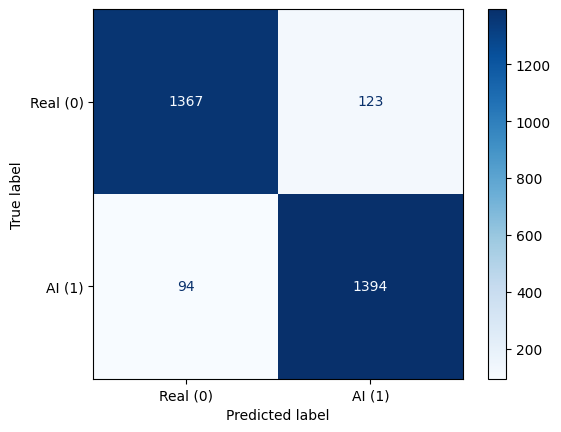

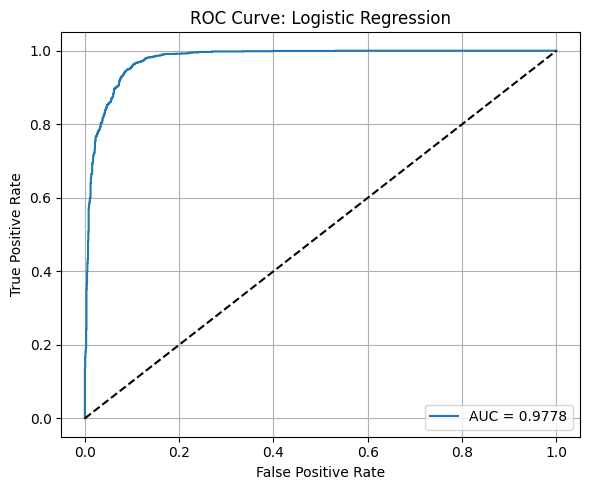


Evaluating Final Model (SVM (Linear))...
 Wrapping LinearSVC with CalibratedClassifierCV for probability support...

📘 Final Model (SVM (Linear)) Performance
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      1490
AI-generated       1.00      1.00      1.00      1488

    accuracy                           1.00      2978
   macro avg       1.00      1.00      1.00      2978
weighted avg       1.00      1.00      1.00      2978


 Confusion Matrix for Final Model (SVM (Linear)):
[[1490    0]
 [   0 1488]]

 ROC Curve for Final Model (SVM (Linear))


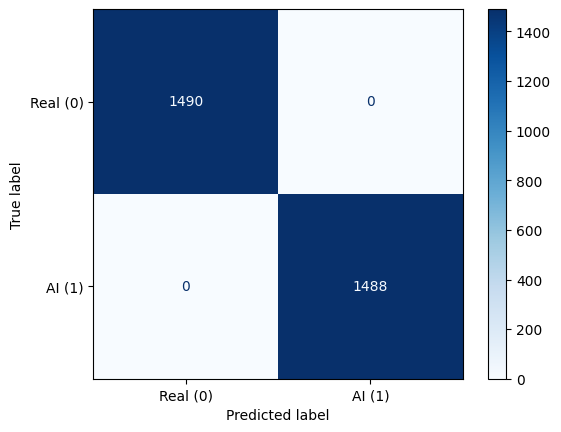

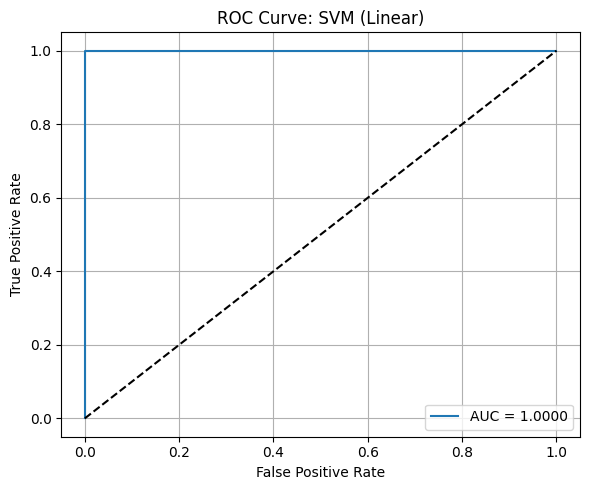

In [38]:
for name, model in final_models:
    evaluate_on_test_set(name, model, X_test_scaled, y_test)


### My observations

#### SVM RBF model
The confusion matrix shows near-perfect classification: only 43 misclassifications out of ~2,978 samples.
The ROC curve demonstrates excellent class separability with an AUC of 0.9986, indicating minimal overlap between classes.

#### Logistic Regression
The confusion matrix shows a notable increase in misclassifications compared to SVM RBF: 217 errors (123 false positives, 94 false negatives).
The ROC curve still shows strong class separability with an AUC of 0.9778, which is very good but slightly lower than the SVM RBF.

#### Linear SVM
The confusion matrix shows perfect classification: 0 false positives, 0 false negatives—100% accuracy on the training set.
The ROC curve has an AUC of 1.000, suggesting complete class separability with no error.
This is unexpected and there must have been some overfitting to the training data that creeped up in this model.

##### My Reflections
1. With more diverse data, I was able to avoid the extreme overfitting that occurred in my previous attempt.
2. I also selected only the top 3 features instead of 5 to help prevent overfitting.
3. I wasn't able to try increasing regularization by lowering the C value or applying stronger cross-validation (e.g., CV=5 or CV=10) for my SVMs, as I'm still using the same hardware.